GOAL: This project explores the CIC-Darknet2020 dataset to uncover meaningful patterns in encrypted internet traffic. By applying statistical analysis, dimensionality reduction, clustering, and anomaly detection, the code (and report that it comes with) aim to highlight both normal and suspicious traffic behaviors in a cybersecurity context.

Run the following helper functions

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import ks_2samp
import itertools
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.patches as mpatches
from scipy.spatial.distance import cdist
from sklearn.neighbors import LocalOutlierFactor


# Loads the dataset from a csv file
def load_data(file_path, columns_to_numeric):
    df = pd.read_csv(file_path, engine='python')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')
    return df

# Cleans the dataset by removing rows with NaN values
def clean_data(df):
    return df.dropna()

# Plots a correlation heatmap for the specified columns
def plot_correlation_heatmap(df, columns):
    corr_matrix = df[columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                linewidths=0.5, square=True, cbar_kws={'label': 'Correlation Coefficient (R)'})
    plt.title("Correlation Matrix with R-values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Checks for missing values in the dataset and prints the count of missing values per column
def analyze_missing_values(df):
    print("Missing values per column:\n")
    missing_counts = df.isnull().sum()
    for col, count in missing_counts.items():
        if count > 0:
            print(f"{col}: {count}")

# Prints rows with missing values 
def print_missing_rows(df):
    for col in df.columns:
        missing_rows = df[df[col].isna()]
        if not missing_rows.empty:           
            print(f"Rows with missing values in column '{col}':\n")
            print(missing_rows)

# Plots density distributions for each numeric column in the dataset
def plot_density_per_column(df):
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(data=df, x=col, fill=True)
        plt.title(f"Density Plot: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.tight_layout()
        plt.show()

# Describes the distribution and frequency of labels in the dataset
def describe_label_distribution(df, label_col='Label'):
    labels = df[label_col]
    label_counts = labels.value_counts(normalize=True) * 100
    print("Label Frequencies (%):")
    for label, pct in label_counts.items():
        print(f"- {label}: {pct:.2f}%")
    mode_label = labels.mode().iloc[0]
    mode_count = (labels == mode_label).sum()
    mode_pct = label_counts[mode_label]
    print(f"\nMost frequent label: {mode_label} ({mode_count} occurrences, {mode_pct:.2f}%)")

# Describes the variables in the dataset, including their scales and statistics
def describe_variables(df, variable_info):
    for col, scale in variable_info.items():
        print(f"\nVariable: {col}")
        print(f"Scale: {scale.capitalize()}")
        col_data = df[col].dropna()
        if not col_data.empty:
            mode = col_data.mode().iloc[0]
            mode_count = (col_data == mode).sum()
            mode_pct = (mode_count / len(col_data)) * 100
            print(f"Mode: {mode} ({mode_count} occurrences, {mode_pct:.2f}%)")
        else:
            print("Mode: N/A")

        if scale in ['ordinal', 'interval', 'ratio']:
            print(f"Median: {col_data.median()}")
        if scale in ['interval', 'ratio']:
            print(f"Mean: {col_data.mean()}")
            print(f"Standard Deviation: {col_data.std()}")

# Removes duplicate rows from the dataset
def remove_duplicate_rows(df):
    df.drop_duplicates(inplace=True)

def flag_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_col_name = f"{column}_Outlier"
    df[outlier_col_name] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df, lower_bound, upper_bound

def apply_outlier_flagging(df, columns):
    for col in columns:
        df, lb, ub = flag_outliers_iqr(df, col)
        outlier_col = f"{col}_Outlier"
        num_outliers = df[outlier_col].sum()
        total = len(df)
        percentage = (num_outliers / total) * 100

        print(f"Outlier threshold for {col}:")
        print(f" - Lower bound: {lb}")
        print(f" - Upper bound: {ub}")
        print(f" - Number of outliers in '{col}': {num_outliers} ({percentage:.2f}%)\n")
    return df

def analyze_outlier_overlap(df, outlier_columns):
    print("\nOutlier Overlap Matrix (% of shared outliers):\n")
    for col1 in outlier_columns:
        for col2 in outlier_columns:
            if col1 == col2:
                continue
            # Rows where both columns are marked as outliers
            both_outliers = df[df[col1] & df[col2]]
            count = len(both_outliers)

            # % of outliers in col1 that are also outliers in col2
            col1_outliers = df[df[col1]]
            percent = (count / len(col1_outliers) * 100) if len(col1_outliers) else 0
            if percent >= 50:
                print(f"{col1} ∩ {col2}: {count} rows ({percent:.2f}%)")


def pca_spss_style(df, columns, n_components=None):
    """
    Perform PCA and print SPSS-style tables: variance explained and component matrix.

    Parameters:
        df (pd.DataFrame): Cleaned dataframe.
        columns (list): Numeric columns to include in PCA.
        n_components (int or None): Number of components (default = all).
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[columns])

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    components = pca.transform(X_scaled)

    # Explained Variance Table
    eigenvalues = pca.explained_variance_
    variance_ratios = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratios)

    variance_df = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
        'Eigenvalue': eigenvalues,
        '% of Variance': variance_ratios * 100,
        'Cumulative %': cumulative_variance * 100
    })

    print("\n--- Total Variance ---")
    print(variance_df.round(2).to_string(index=False))

    # Component Loadings (Component Matrix)
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                            index=columns)

    print("\n--- Component Matrix --")
    print(loadings.round(2))

    return variance_df, loadings, pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

def run_kmeans_pca_analysis(pca_data, max_k=10):
    inertias = []
    silhouettes = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(pca_data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(pca_data, labels))

    # Plot elbow curve
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouettes, marker='o')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

    # Return both lists to help decide
    return inertias, silhouettes

def detect_anomalies_isolation_forest(df, features, contamination=0.01):

    clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    X = df[features].dropna()
    clf.fit(X)
    
    anomaly_labels = clf.predict(X)
    anomaly_scores = clf.decision_function(X)
    
    df.loc[X.index, 'AnomalyIF'] = (anomaly_labels == -1).astype(int)
    df.loc[X.index, 'Anomaly_ScoreIF'] = -anomaly_scores  # Higher = more anomalous

    return df


def plot_3d_clusters_sampled(pca_df, labels, sample_size=5000):
    if not isinstance(labels, pd.Series):
        labels = pd.Series(labels, index=pca_df.index)

    # Create a new DataFrame combining PCA and labels
    combined_df = pca_df.copy()
    combined_df["Cluster"] = labels

    # Stratified sampling: keep at least some of each cluster
    sampled_df = combined_df.groupby("Cluster", group_keys=False).apply(
        lambda x: x.sample(min(len(x), sample_size // len(combined_df["Cluster"].unique())), random_state=42)
    )

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        sampled_df['PC1'],
        sampled_df['PC2'],
        sampled_df['PC3'],
        c=sampled_df['Cluster'],
        cmap='tab10',
        s=10,
        alpha=0.7
    )

    ax.set_title("3D PCA Cluster Visualization (sampled, stratified)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.tight_layout()
    plt.show()


def run_kmeans_clustering(pca_data, n_clusters):
    """
    Runs KMeans on PCA-transformed data with a specified number of clusters.

    Parameters:
        pca_data (pd.DataFrame or np.ndarray): PCA-reduced feature data
        n_clusters (int): Number of clusters to form

    Returns:
        labels (np.ndarray): Cluster labels for each point
        kmeans (KMeans): The fitted KMeans model
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    return labels, kmeans


def plot_elbow_method(data, max_k=10):
    inertias = []
    ks = range(1, max_k + 1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (within-cluster sum of squares)')
    plt.xticks(ks)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def interpret_clusters(df, feature_columns):
    summary = df.groupby('Cluster')[feature_columns].agg(['mean', 'std']).round(2)
    return summary


def plot_normalized_cluster_mean_heatmap(df, feature_columns, cluster_col='Cluster'):
    """
    Plots a heatmap of normalized mean feature values for each cluster.
    Values are normalized per feature using min-max scaling for comparability.
    """
    cluster_means = df.groupby(cluster_col)[feature_columns].mean()
    
    # Min-max normalization (column-wise)
    cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means_normalized, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title("Normalized Heatmap of Cluster Mean Feature Values")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()


def temporal_analysis(file_path, timestamp_col='Timestamp', cluster_col='Cluster'):
    # Load data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Parse timestamp
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format="%d/%m/%Y %I:%M:%S %p", errors='coerce')
    df = df.dropna(subset=[timestamp_col, cluster_col])  # Drop bad timestamps or missing clusters

    # Extract temporal features
    df['Hour'] = df[timestamp_col].dt.hour
    df['DayOfWeek'] = df[timestamp_col].dt.day_name()

    # Plot hourly distribution for each cluster
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Hour', hue=cluster_col, palette='tab10')
    plt.title('Cluster Activity by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    # Plot day of week distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='DayOfWeek', hue=cluster_col, order=[
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    plt.title('Cluster Activity by Day of Week')
    plt.xlabel('Day')
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    hourly_summary = df.groupby([cluster_col, 'Hour']).size().unstack(fill_value=0)
    daily_summary = df.groupby([cluster_col, 'DayOfWeek']).size().unstack(fill_value=0)
    hourly_summary.to_csv("hourly_cluster_distribution.csv")
    daily_summary.to_csv("daily_cluster_distribution.csv")


def run_temporal_ks_tests(df, features, time_col='Hour', cluster_col='Cluster'):
    results = []

    time_groups = df[time_col].dropna().unique()
    for time_val in sorted(time_groups):
        df_time = df[df[time_col] == time_val]
        clusters = df_time[cluster_col].dropna().unique()
        cluster_pairs = list(itertools.combinations(clusters, 2))

        for feature in features:
            for c1, c2 in cluster_pairs:
                x = df_time[df_time[cluster_col] == c1][feature].dropna()
                y = df_time[df_time[cluster_col] == c2][feature].dropna()

                if len(x) > 0 and len(y) > 0:
                    stat, p = ks_2samp(x, y)
                    results.append({
                        'Time': time_val,
                        'Feature': feature,
                        'Cluster 1': c1,
                        'Cluster 2': c2,
                        'KS Statistic (D)': round(stat, 4),
                        'Raw p-value': p
                    })

    ks_df = pd.DataFrame(results)

    # Apply Bonferroni correction
    m = len(ks_df)
    ks_df['Bonferroni alpha'] = 0.05 / m
    ks_df['Adjusted Significant'] = ks_df['Raw p-value'] < ks_df['Bonferroni alpha']
    ks_df['Adjusted p-value'] = ks_df['Raw p-value'] * m
    ks_df['Adjusted p-value'] = ks_df['Adjusted p-value'].clip(upper=1.0)  # Ensure max 1.0

    return ks_df



def extract_ip_pair(flow_id):
    try:
        src_ip, dst_ip, *_ = flow_id.split('-')
        return src_ip, dst_ip
    except:
        return None, None

def build_info_flow_graph(df, flow_column='Flow ID'):
    # Step 1: Extract source and destination IPs
    df[['SrcIP', 'DstIP']] = df[flow_column].apply(lambda x: pd.Series(extract_ip_pair(x)))
    
    # Step 2: Create directed graph
    G = nx.DiGraph()
    
    # Step 3: Add edges for each flow
    for _, row in df.iterrows():
        if pd.notna(row['SrcIP']) and pd.notna(row['DstIP']):
            G.add_edge(row['SrcIP'], row['DstIP'])
    
    return G

def plot_info_flow_graph(G, max_nodes=100):

    if len(G.nodes) > max_nodes:
        print(f"Showing only {max_nodes}.")
        G = G.subgraph(list(G.nodes)[:max_nodes])

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)  # layout with spacing

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Draw edges with arrows
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        arrows=True,
        arrowstyle='-|>',    \
        arrowsize=20,
        connectionstyle='arc3,rad=0.1'  \
    )

    plt.title("Directed Information Flow Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def summarize_anomalies_by_cluster(df, cluster_col='Cluster', anomaly_col='Anomaly'):
    """
    Returns a summary DataFrame with anomaly counts and percentages for each cluster.
    """
    anomalies = df[df[anomaly_col] == 1][cluster_col].value_counts().sort_index()
    normals = df[df[anomaly_col] == 0][cluster_col].value_counts().sort_index()

    summary_df = pd.DataFrame({
        'Anomalies': anomalies,
        'Normal': normals
    }).fillna(0)

    summary_df['Total'] = summary_df['Anomalies'] + summary_df['Normal']
    summary_df['Anomaly Rate (%)'] = 100 * summary_df['Anomalies'] / summary_df['Total']
    return summary_df

def plot_anomaly_rates(summary_df):
    """
    Plots anomaly rates per cluster from a summary DataFrame.
    """
    summary_df = summary_df.copy()

    # Only reset index if 'Cluster' is not already a column
    if 'Cluster' not in summary_df.columns:
        summary_df['Cluster'] = summary_df.index

    plt.figure(figsize=(8, 5))
    sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')
    plt.title("Anomaly Rate per Cluster")
    plt.ylabel("Anomaly Percentage")
    plt.xlabel("Cluster")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


def compare_anomaly_distributions(df, features, cluster_col='Cluster', anomaly_col='Anomaly'):
    """
    Plots KDE plots for each feature and cluster, comparing anomaly vs normal.
    """
    unique_clusters = sorted(df[cluster_col].dropna().unique())

    for cluster_id in unique_clusters:
        for feature in features:
            plt.figure(figsize=(8, 4))
            subset = df[df[cluster_col] == cluster_id]

            sns.kdeplot(subset[subset[anomaly_col] == 0][feature], label='Normal', fill=True)
            sns.kdeplot(subset[subset[anomaly_col] == 1][feature], label='Anomaly', fill=True)

            plt.title(f"{feature} Distribution in Cluster {cluster_id}")
            plt.xlabel(feature)
            plt.legend()
            plt.tight_layout()
            plt.show()


def geometric_median(X, eps=1e-5):
    y = np.mean(X, axis=0)
    while True:
        D = np.linalg.norm(X - y, axis=1)
        nonzeros = D != 0
        if not np.any(nonzeros):
            return y
        Dinv = 1 / D[nonzeros]
        W = Dinv / Dinv.sum()
        T = (X[nonzeros] * W[:, None]).sum(axis=0)
        if np.linalg.norm(y - T) < eps:
            return T
        y = T

def geometric_median_outliers(df, features, threshold_percentile=95):
    X = df[features].dropna().values
    gm = geometric_median(X)
    distances = np.linalg.norm(X - gm, axis=1)
    
    threshold = np.percentile(distances, threshold_percentile)
    
    outlier_mask = distances > threshold
    df.loc[df[features].dropna().index, 'GeoMed_Outlier'] = outlier_mask.astype(int)
    df.loc[df[features].dropna().index, 'GeoMed_Distance'] = distances
    return df

def plot_geomed_outliers_pca(pca_df, df, outlier_col='GeoMed_Outlier', title_suffix=""):

    # Merge PCA with outlier flags
    plot_df = pca_df[['PC1', 'PC2']].copy()
    plot_df[outlier_col] = df[outlier_col]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=plot_df,
        x='PC1',
        y='PC2',
        hue=plot_df[outlier_col].map({0: "Normal", 1: "Outlier"}),
        palette={"Normal": "blue", "Outlier": "red"},
        alpha=0.5,
        s=10
    )
    
    plt.title(f"Geometric Median Outliers in PCA Space {title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    legend_handles = [
        mpatches.Patch(color='blue', label='Normal'),
        mpatches.Patch(color='red', label='Outlier')
    ]
    plt.legend(handles=legend_handles, title="Status")
    plt.tight_layout()
    plt.show()


def _mad_flags(x, z_thresh=3.5):
    x = pd.to_numeric(x, errors='coerce')
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    mad_n = 1.4826 * mad if np.isfinite(mad) else np.nan   # normalized MAD
    if (not np.isfinite(mad_n)) or mad_n == 0:
        return pd.Series(False, index=x.index), med, mad_n
    z = np.abs(x - med) / mad_n
    return (z > z_thresh), med, mad_n


def detect_anomalies_oneclass_svm_on_pcs(
    df: pd.DataFrame,
    pc_scores_df: pd.DataFrame,
    nu: float = 0.02,
    train_n: int = 20000,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Fits RBF One-Class SVM on *existing PCA components* (PC1..PCk).
    Safe write-back using drop-then-join; no KeyError or overlap errors.
    """
    # --- 1) Grab PCA matrix ---
    pc_cols = [c for c in pc_scores_df.columns if c.upper().startswith("PC")]
    if not pc_cols:
        raise ValueError("pc_scores_df must have columns named like 'PC1','PC2', ...")
    Z = pc_scores_df[pc_cols].to_numpy()

    # --- 2) Subsample to fit (for speed on ~100k) ---
    rng = np.random.default_rng(random_state)
    fit_idx = rng.choice(Z.shape[0], size=min(train_n, Z.shape[0]), replace=False)

    # --- 3) Train + score ---
    oc = OneClassSVM(kernel="rbf", gamma="scale", nu=nu)
    oc.fit(Z[fit_idx])

    scores = -oc.decision_function(Z).ravel()        # higher = more anomalous
    flags  = (oc.predict(Z) == -1).astype(int)       # 1 = anomaly

    # --- 4) Build results indexed like pc_scores_df ---
    ocsvm_res = pd.DataFrame(
        {"OCSVM_Score": scores, "Anomaly_OCSVM": flags},
        index=pc_scores_df.index
    )

    # --- 5) Idempotent write-back: drop overlapping cols, then join ---
    overlap = [c for c in ocsvm_res.columns if c in df.columns]
    df_out = df.drop(columns=overlap, errors="ignore").join(ocsvm_res, how="left")

    return df_out

def plot_geomed_distance_histogram(df, distance_col='GeoMed_Distance', threshold_percentile=95):
    threshold = np.percentile(df[distance_col].dropna(), threshold_percentile)
    
    plt.figure(figsize=(8, 5))
    sns.histplot(df[distance_col], bins=100, kde=True)
    plt.axvline(threshold, color='red', linestyle='--', label=f'{threshold_percentile}th percentile')
    plt.title("Distribution of Distances from Geometric Median")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

Setup, the following columns were selected for their theoritical and practicial relationships (see report)

In [28]:
file_path = "DarknetWorking.csv"
selected_columns = [
    'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Mean',
    'Bwd Packet Length Mean', 'Packet Length Std', 'Idle Mean'
]

variable_scales = {col: 'ratio' for col in selected_columns}

Loading data, and looking at missing values per column.

In [29]:
df = load_data(file_path, selected_columns)
analyze_missing_values(df)
print_missing_rows(df)
df = clean_data(df)

Missing values per column:

Flow Bytes/s: 49
Flow Packets/s: 49
Rows with missing values in column 'Flow Bytes/s':

                                           Flow ID  ...    Label
32903     173.194.40.103-10.152.152.11-443-52701-6  ...  Non-Tor
33148          2.22.9.25-10.152.152.11-443-37492-6  ...  Non-Tor
33174         31.13.93.7-10.152.152.11-443-41051-6  ...  Non-Tor
33324      173.194.67.16-10.152.152.11-465-35807-6  ...  Non-Tor
33597     173.194.207.16-10.152.152.11-465-33190-6  ...  Non-Tor
35854      10.152.152.11-54.230.228.31-47339-443-6  ...  Non-Tor
36427       46.228.164.20-10.152.152.11-80-44537-6  ...  Non-Tor
36631      23.206.24.104-10.152.152.11-443-60982-6  ...  Non-Tor
36641         10.152.152.11-31.13.64.1-45140-443-6  ...  Non-Tor
36648    173.241.240.220-10.152.152.11-443-56194-6  ...  Non-Tor
36760     10.152.152.10-10.152.152.11-9052-46623-6  ...  Non-Tor
36861       23.34.180.136-10.152.152.11-80-60162-6  ...  Non-Tor
37393       23.235.37.134-10.152.152.11

Meta Data, first, viewing the relationship between the selected columns to learn more about the variables. Then, looking at the distribution of each vairable on its own, to learn more about it:

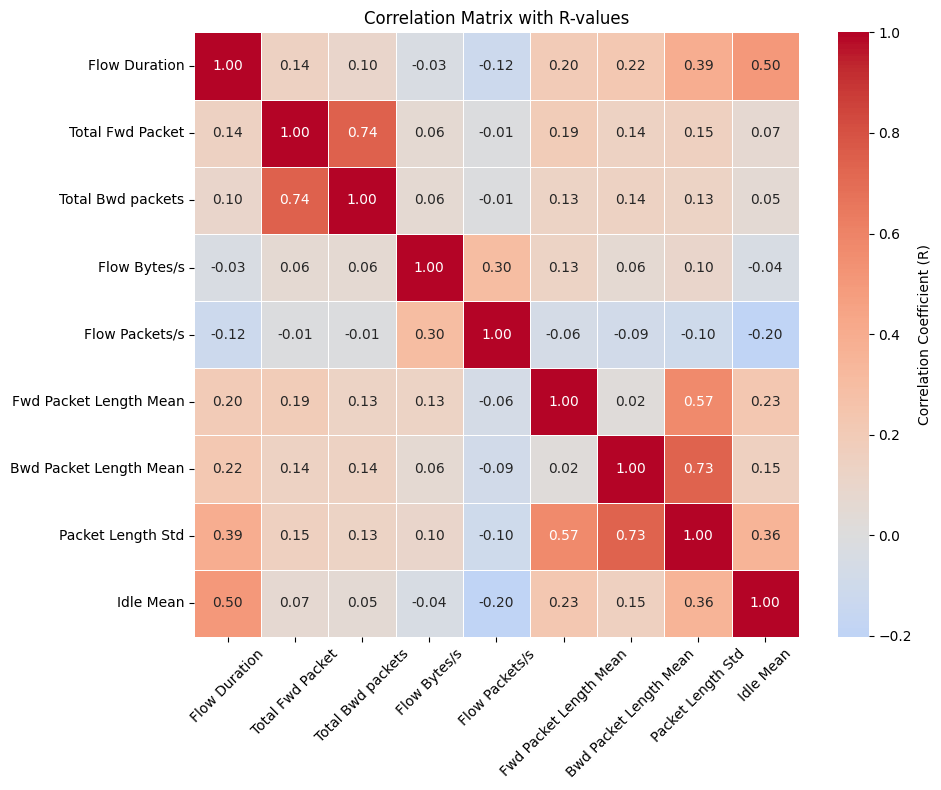

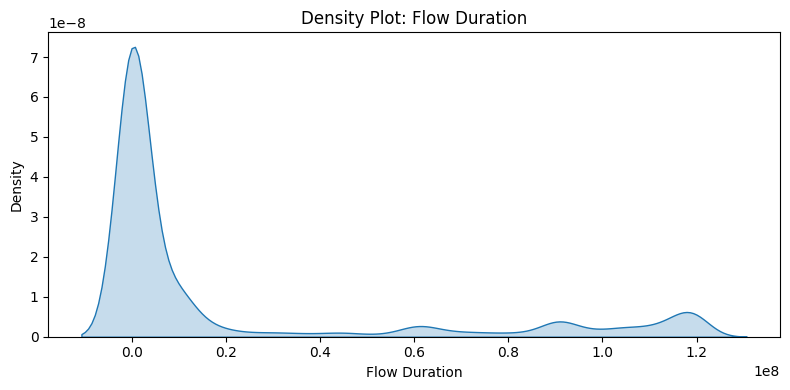

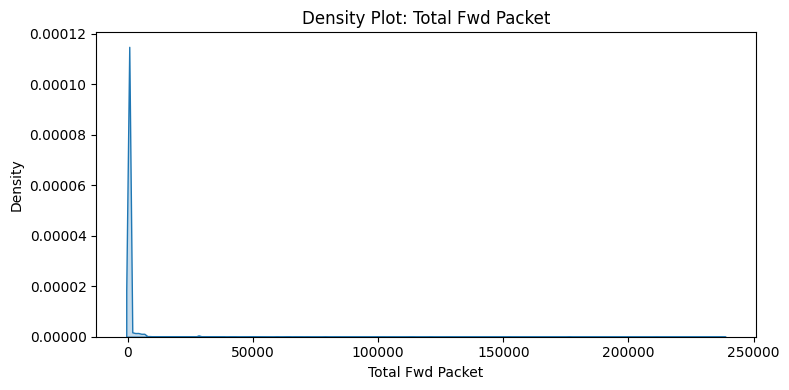

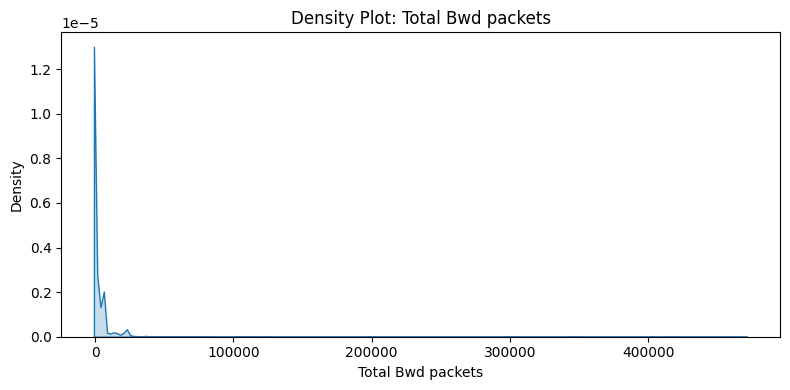

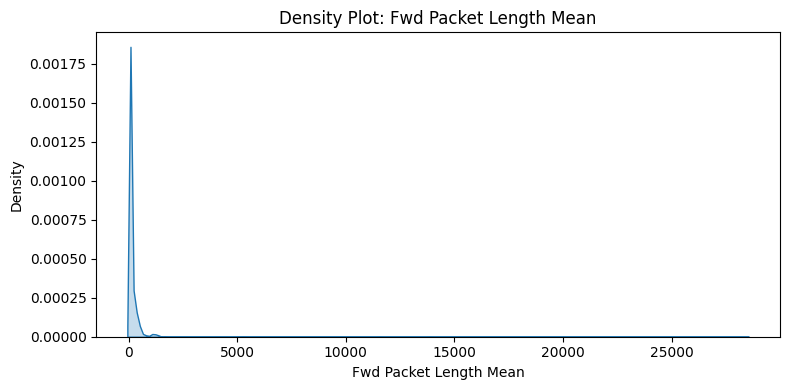

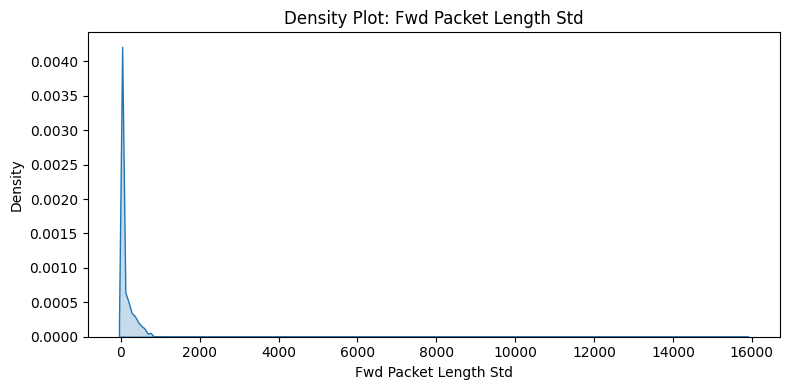

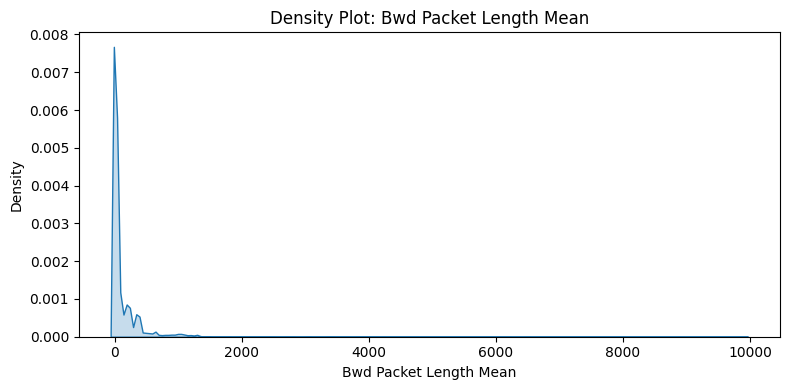

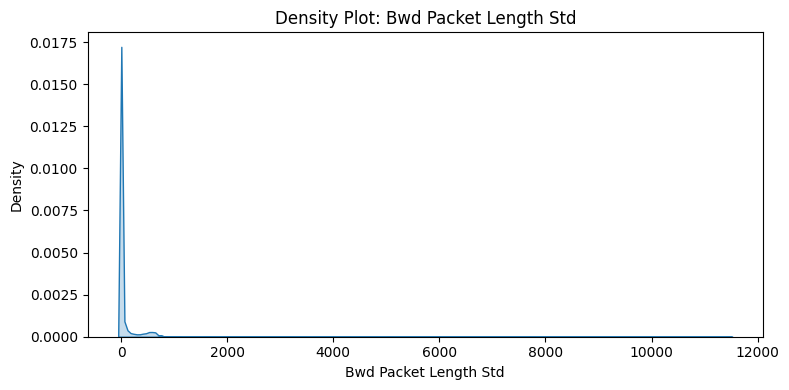

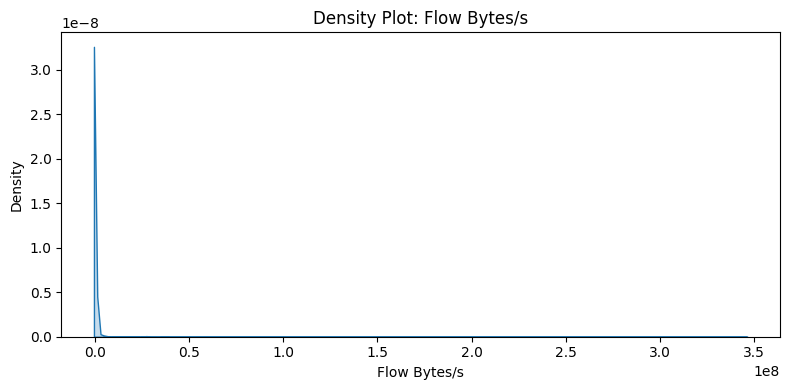

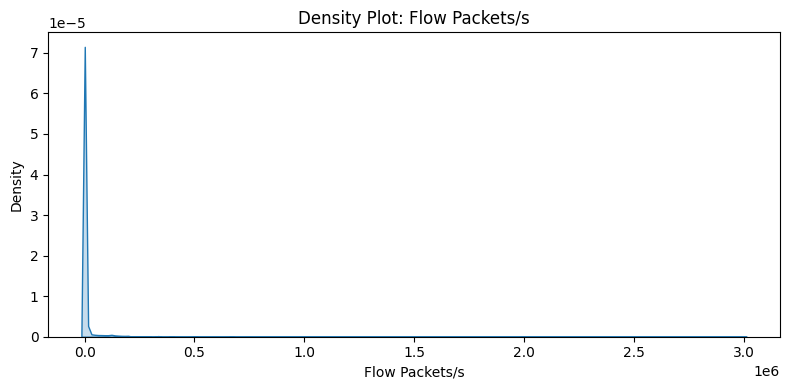

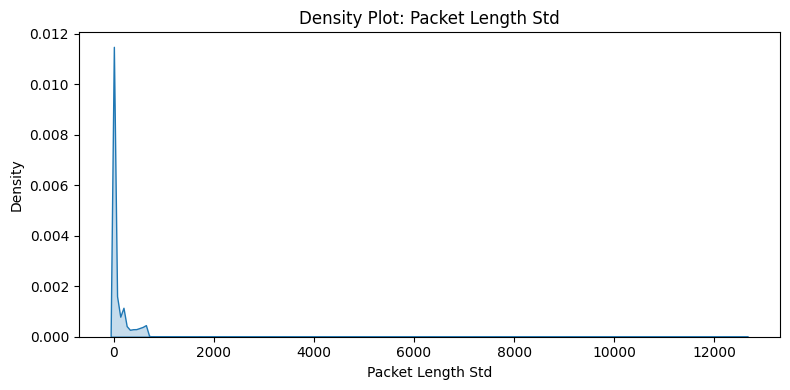

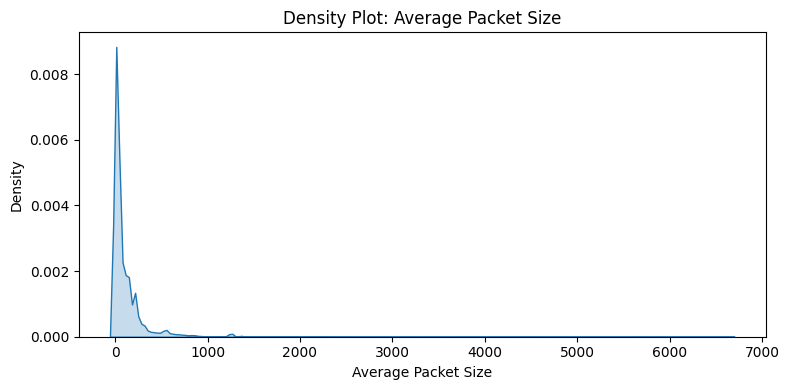

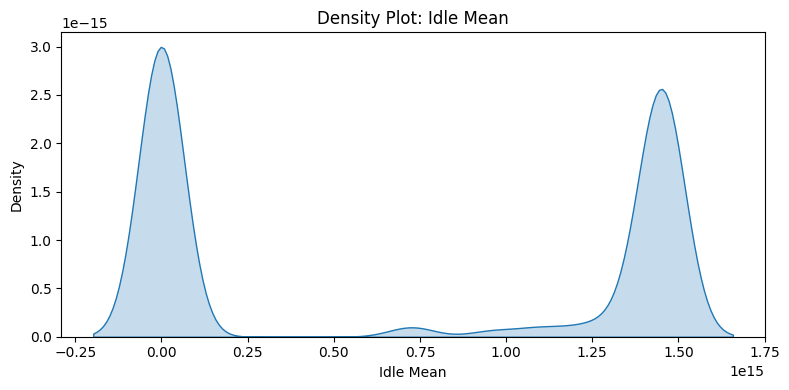

Label Frequencies (%):
- Non-Tor: 65.95%
- NonVPN: 16.87%
- VPN: 16.20%
- Tor: 0.98%
- 5494.505495: 0.00%

Most frequent label: Non-Tor (93309 occurrences, 65.95%)

Variable: Flow Duration
Scale: Ratio
Mode: 16 (527 occurrences, 0.37%)
Median: 416430.5
Mean: 20819965.825695142
Standard Deviation: 38096045.20688477

Variable: Total Fwd Packet
Scale: Ratio
Mode: 1 (40802 occurrences, 28.84%)
Median: 2.0
Mean: 152.8523063004481
Standard Deviation: 2378.725115707975

Variable: Total Bwd packets
Scale: Ratio
Mode: 1 (44488 occurrences, 31.44%)
Median: 1.0
Mean: 154.69426499484032
Standard Deviation: 3419.2939935341997

Variable: Flow Bytes/s
Scale: Ratio
Mode: 0.0 (38043 occurrences, 26.89%)
Median: 74.074138145
Mean: 85114.48474351196
Standard Deviation: 1253100.9814775246

Variable: Flow Packets/s
Scale: Ratio
Mode: 125000.0 (528 occurrences, 0.37%)
Median: 7.2878064259999995
Mean: 10900.175744007498
Standard Deviation: 51407.08693165147

Variable: Fwd Packet Length Mean
Scale: Ratio
Mode

In [30]:
plot_correlation_heatmap(df, selected_columns)
plot_density_per_column(df)
describe_label_distribution(df, label_col='Label')
describe_variables(df, variable_scales)

Count how many duplicate rows there are and delete them

In [31]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
# Remove duplicate rows
remove_duplicate_rows(df)

Number of duplicate rows: 24457


Outlier Detection and Analysis (For each variable), then, we looked at the overlap of outliers (The outlier analysis was using 1.5IQR)

In [32]:
df = apply_outlier_flagging(df, selected_columns)
output_path = "DarknetWorking_with_outliers.csv"
df.to_csv(output_path, index=False)
analyze_outlier_overlap(df, [f"{col}_Outlier" for col in selected_columns])

Outlier threshold for Flow Duration:
 - Lower bound: -14848417.0
 - Upper bound: 24749815.0
 - Number of outliers in 'Flow Duration': 24269 (20.74%)

Outlier threshold for Total Fwd Packet:
 - Lower bound: -3.5
 - Upper bound: 8.5
 - Number of outliers in 'Total Fwd Packet': 19596 (16.75%)

Outlier threshold for Total Bwd packets:
 - Lower bound: -4.5
 - Upper bound: 7.5
 - Number of outliers in 'Total Bwd packets': 18367 (15.69%)

Outlier threshold for Flow Bytes/s:
 - Lower bound: -2361.696789
 - Upper bound: 3936.1613150000003
 - Number of outliers in 'Flow Bytes/s': 22117 (18.90%)

Outlier threshold for Flow Packets/s:
 - Lower bound: -3482.21784572
 - Upper bound: 5805.939302631999
 - Number of outliers in 'Flow Packets/s': 15769 (13.47%)

Outlier threshold for Fwd Packet Length Mean:
 - Lower bound: -66.0
 - Upper bound: 110.0
 - Number of outliers in 'Fwd Packet Length Mean': 14745 (12.60%)

Outlier threshold for Bwd Packet Length Mean:
 - Lower bound: -229.5
 - Upper bound: 382

Analyzing outliers depending on Median Absolute Deviation (MAD)

In [33]:
rows = []
iqr_any = pd.Series(False, index=df.index)
mad_any = pd.Series(False, index=df.index)
total_n = len(df)

for col in selected_columns:
    # ensure IQR flags exist (<col>_Outlier)
    iqr_col = f"{col}_Outlier"
    if iqr_col not in df.columns:
        Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df[iqr_col] = (df[col] < lb) | (df[col] > ub)
    a = pd.to_numeric(df[iqr_col], errors="coerce").fillna(0).astype(bool)

    # MAD flags (writes <col>_MAD_Outlier)
    b, med, mad_n = _mad_flags(df[col])
    df[f"{col}_MAD_Outlier"] = b

    n_iqr  = int(a.sum())
    n_mad  = int(b.sum())
    both   = int((a & b).sum())
    union  = int((a | b).sum())
    jacc   = (both / union) if union else np.nan

    rows.append({
        "feature": col,
        "IQR_n": n_iqr,
        "IQR_pct": round(n_iqr / total_n * 100, 2),
        "MAD_n": n_mad,
        "MAD_pct": round(n_mad / total_n * 100, 2),
        "Overlap_both": both,
        "Overlap_both_pct": round(both / total_n * 100, 2),
        "Union": union,
        "Union_pct": round(union / total_n * 100, 2),
        "Jaccard": round(jacc, 4) if pd.notna(jacc) else np.nan,
        "Jaccard_pct": round(jacc * 100, 2) if pd.notna(jacc) else np.nan,
    })

    iqr_any |= a
    mad_any |= b

per_feature = pd.DataFrame(rows)

overall_union = int((iqr_any | mad_any).sum())
overall_both  = int((iqr_any & mad_any).sum())
overall_jacc  = (overall_both / overall_union) if overall_union else np.nan

overall = pd.DataFrame([{
    "feature": "__OVERALL__",
    "IQR_n": int(iqr_any.sum()),
    "IQR_pct": round(int(iqr_any.sum()) / total_n * 100, 2),
    "MAD_n": int(mad_any.sum()),
    "MAD_pct": round(int(mad_any.sum()) / total_n * 100, 2),
    "Overlap_both": overall_both,
    "Overlap_both_pct": round(overall_both / total_n * 100, 2),
    "Union": overall_union,
    "Union_pct": round(overall_union / total_n * 100, 2),
    "Jaccard": round(overall_jacc, 4) if pd.notna(overall_jacc) else np.nan,
    "Jaccard_pct": round(overall_jacc * 100, 2) if pd.notna(overall_jacc) else np.nan,
}])

# Show results
display(per_feature.sort_values("Jaccard", na_position="last"))
display(overall)


,feature,IQR_n,IQR_pct,MAD_n,MAD_pct,Overlap_both,Overlap_both_pct,Union,Union_pct,Jaccard,Jaccard_pct
6,Bwd Packet Length Mean,8442,7.21,54588,46.65,8442,7.21,54588,46.65,0.1546,15.46
7,Packet Length Std,14242,12.17,44728,38.22,14242,12.17,44728,38.22,0.3184,31.84
4,Flow Packets/s,15769,13.47,38244,32.68,15769,13.47,38244,32.68,0.4123,41.23
0,Flow Duration,24269,20.74,40072,34.24,24269,20.74,40072,34.24,0.6056,60.56
3,Flow Bytes/s,22117,18.90,35477,30.32,22117,18.90,35477,30.32,0.6234,62.34
5,Fwd Packet Length Mean,14745,12.60,12217,10.44,12217,10.44,14745,12.60,0.8286,82.86
2,Total Bwd packets,18367,15.69,19379,16.56,18367,15.69,19379,16.56,0.9478,94.78
1,Total Fwd Packet,19596,16.75,20585,17.59,19596,16.75,20585,17.59,0.9520,95.20
8,Idle Mean,0,0.00,0,0.00,0,0.00,0,0.00,NaN,NaN


,feature,IQR_n,IQR_pct,MAD_n,MAD_pct,Overlap_both,Overlap_both_pct,Union,Union_pct,Jaccard,Jaccard_pct
0,__OVERALL__,64181,54.84,98737,84.37,64180,54.84,98738,84.37,0.65,65.0


Geometric Median Outliers


--- Geometric Median Outliers at 95th Percentile ---
Total outliers flagged: 5818.0 / 117025


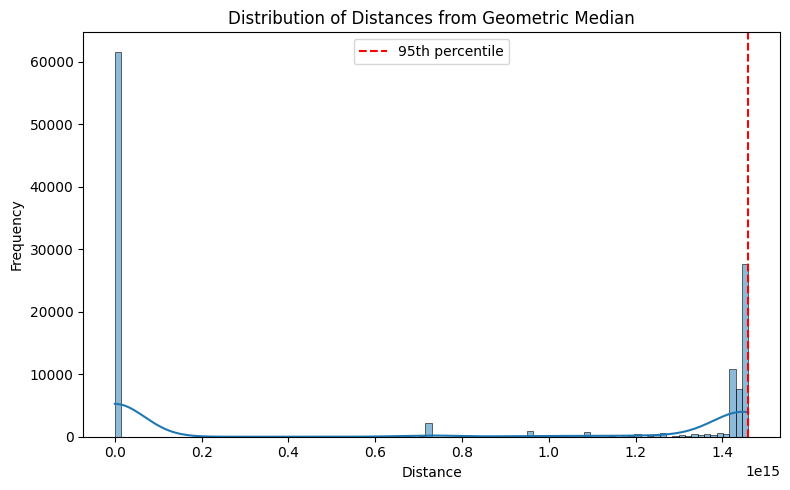

In [34]:
df = geometric_median_outliers(df, selected_columns, threshold_percentile=95)
print(f"\n--- Geometric Median Outliers at 95th Percentile ---")
num_outliers = df['GeoMed_Outlier'].sum()
print(f"Total outliers flagged: {num_outliers} / {len(df)}")

plot_geomed_distance_histogram(df, distance_col='GeoMed_Distance', threshold_percentile=95)

# There's another plot right after PCA analysis to visualize in 2D

PCA analysis - To look into higher components, I ran PCA with 3 components (I also ran with 4 components, but the fourth eigenvalue was close to 1)

In [35]:
variance_df, loadings_df, pc_scores_df = pca_spss_style(df, selected_columns, n_components=3)
pc_scores_df.index = df.index 


--- Total Variance ---
Component  Eigenvalue  % of Variance  Cumulative %
      PC1        2.61          28.96         28.96
      PC2        1.63          18.15         47.12
      PC3        1.35          14.97         62.09

--- Component Matrix --
                         PC1   PC2   PC3
Flow Duration           0.37 -0.21 -0.15
Total Fwd Packet        0.30  0.59 -0.24
Total Bwd packets       0.27  0.60 -0.25
Flow Bytes/s            0.06  0.23  0.62
Flow Packets/s         -0.13  0.26  0.53
Fwd Packet Length Mean  0.34 -0.00  0.21
Bwd Packet Length Mean  0.39 -0.12  0.20
Packet Length Std       0.52 -0.17  0.27
Idle Mean               0.37 -0.29 -0.16


In order to visualize in 2D

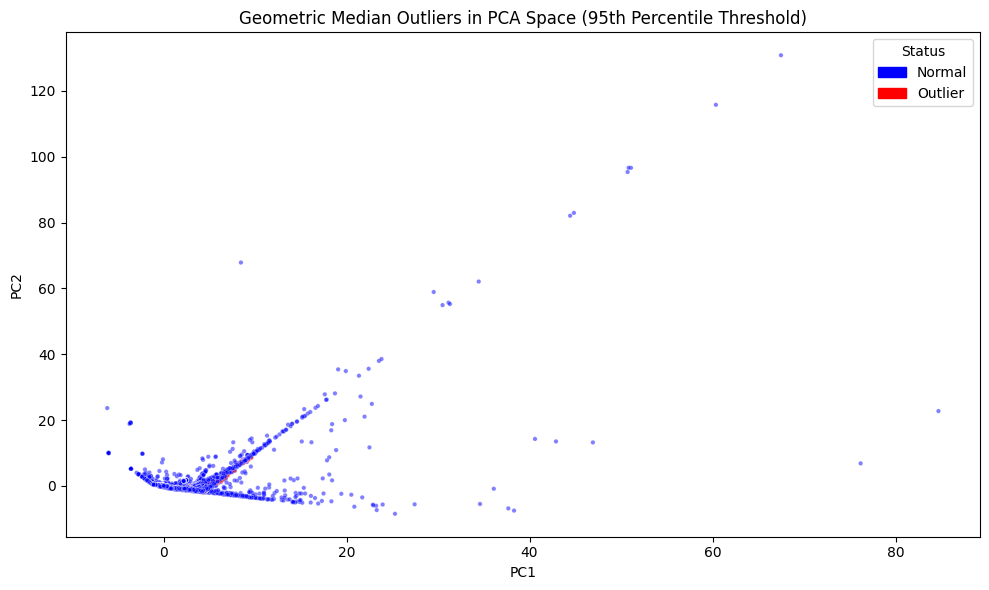

In [36]:
plot_geomed_outliers_pca(pc_scores_df, df, title_suffix="(95th Percentile Threshold)")

Clustering Analysis - using K-means (Max K = 10)

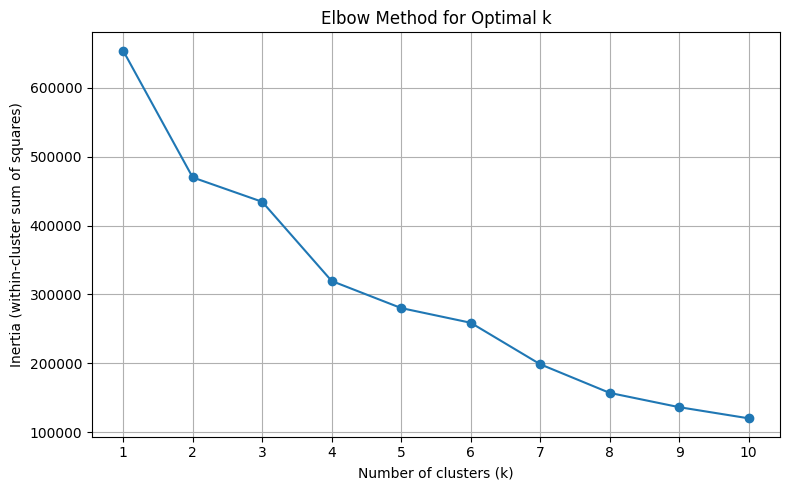

C:\Users\user1\AppData\Local\Temp\ipykernel_14600\1968126179.py:246: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = combined_df.groupby("Cluster", group_keys=False).apply(


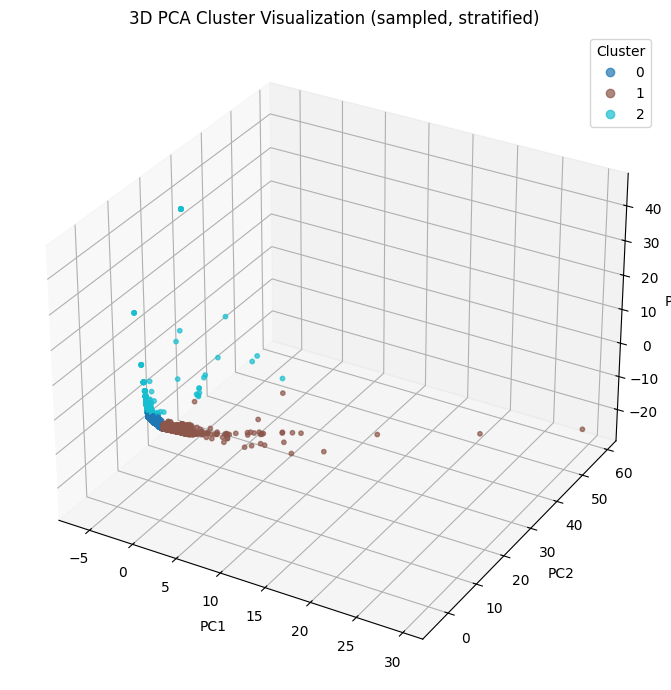

In [37]:
plot_elbow_method(pc_scores_df, max_k=10)
labels, kmeans_model = run_kmeans_clustering(pc_scores_df, n_clusters=3)
df['Cluster'] = labels
df.to_csv("DarknetWorking_with_outliers.csv", index=False)
plot_3d_clusters_sampled(pc_scores_df, df['Cluster'], sample_size=5000)

Detect anomalies using Isolation Forest 

Detected 2341.0 anomalies out of 117025 rows.


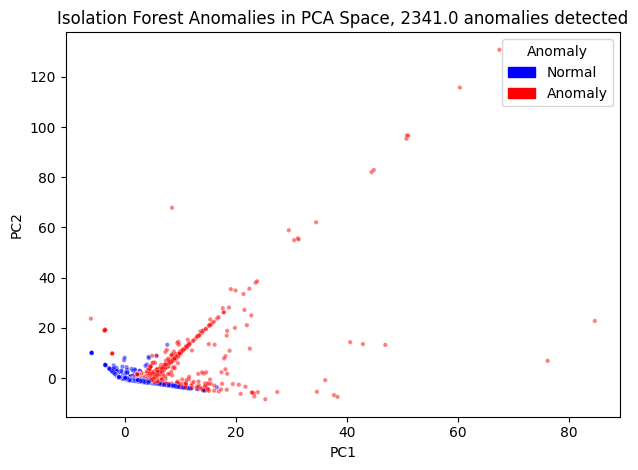

C:\Users\user1\AppData\Local\Temp\ipykernel_14600\1968126179.py:490: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')


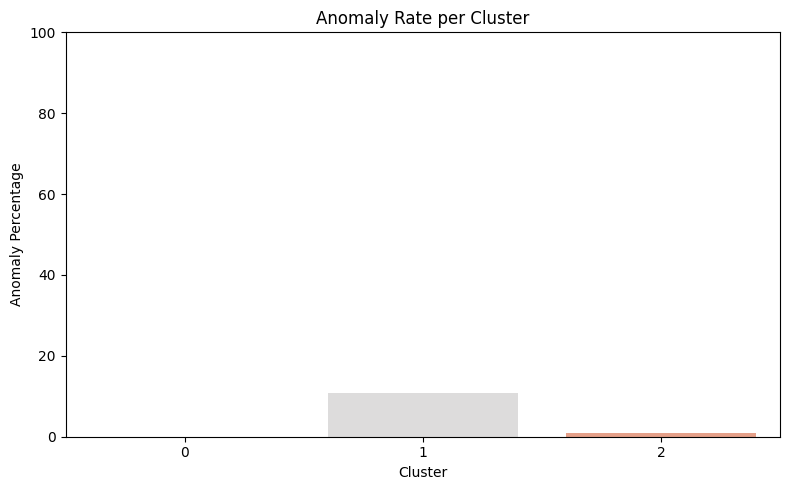

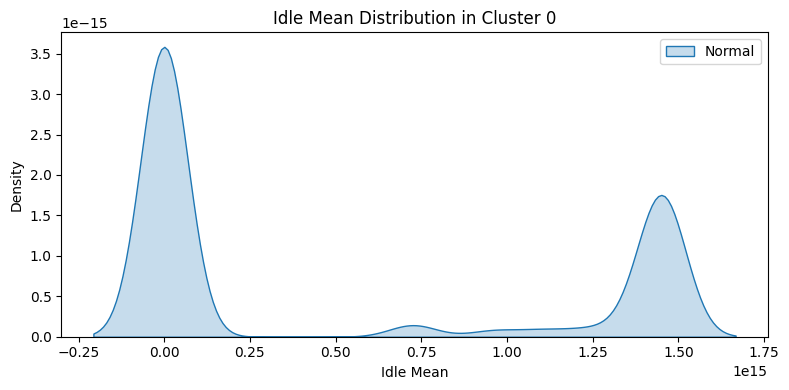

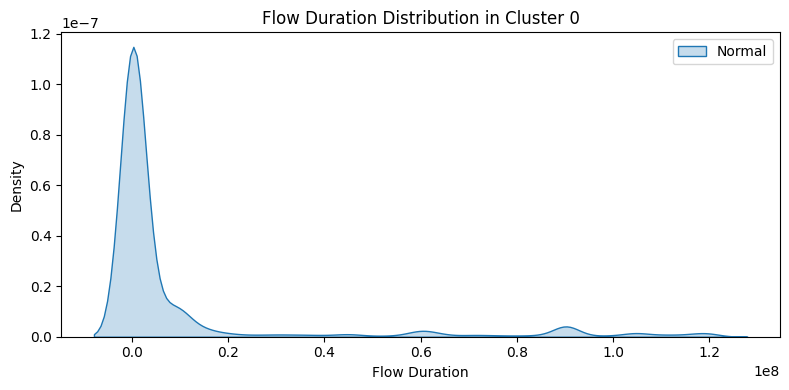

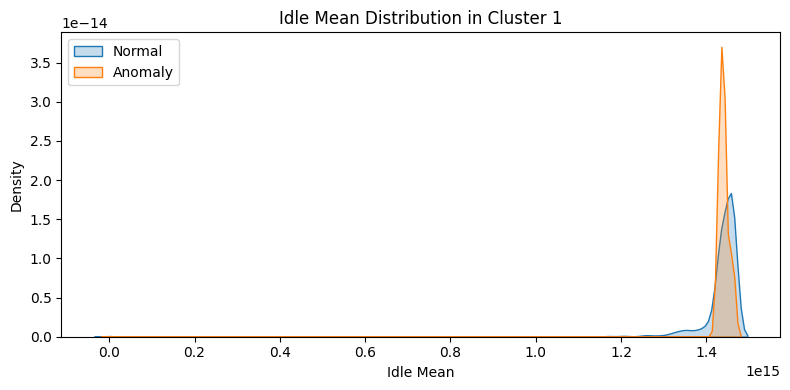

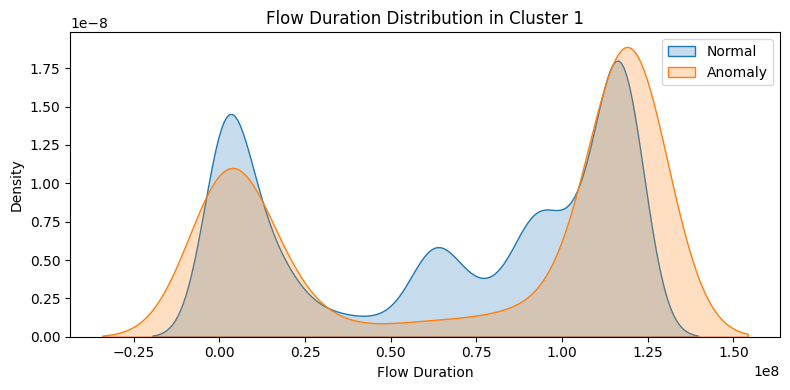

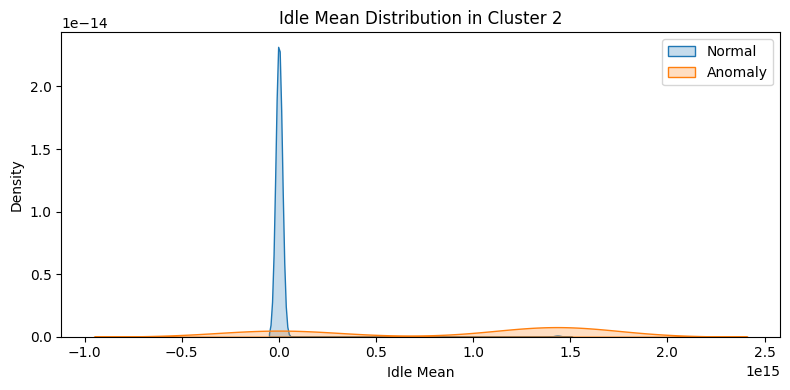

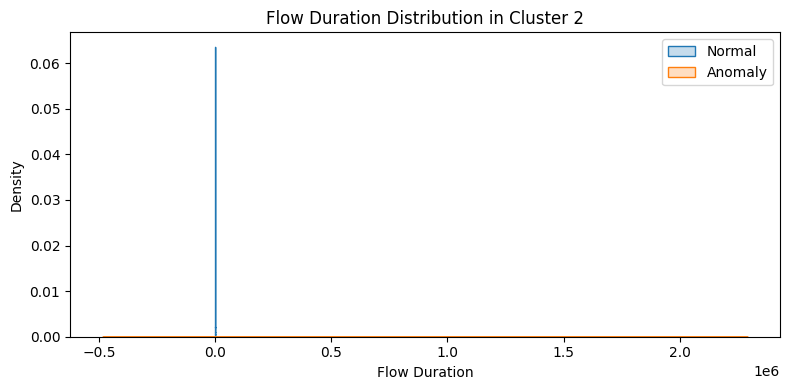

In [38]:
df = detect_anomalies_isolation_forest(df, selected_columns, contamination=0.02)
number_of_anomalies = df['AnomalyIF'].sum()
print(f"Detected {number_of_anomalies} anomalies out of {len(df)} rows.")
# 2D PCA Scatterplot with anomaly overlay
sns.scatterplot(
    x=pc_scores_df['PC1'],
    y=pc_scores_df['PC2'],
    hue=df['AnomalyIF'].map({0: "Normal", 1: "Anomaly"}),
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.5,
    s=10
)
# Create custom legend handles
legend_handles = [
    mpatches.Patch(color='blue', label='Normal'),
    mpatches.Patch(color='red', label='Anomaly')
]
# Set title and labels
plt.title(f"Isolation Forest Anomalies in PCA Space, {number_of_anomalies} anomalies detected")
plt.xlabel("PC1")
plt.ylabel("PC2")
# Apply custom legend
plt.legend(handles=legend_handles, title='Anomaly')
plt.tight_layout()
plt.show()

# Summarize anomalies by cluster and plot
summary_df = summarize_anomalies_by_cluster(df, 'Cluster','AnomalyIF')
plot_anomaly_rates(summary_df)
key_features = ['Idle Mean', 'Flow Duration']
compare_anomaly_distributions(df, key_features,'Cluster','AnomalyIF')

Detect Anomalies using One Class SVM

(OC-SVM) Detected 2600 anomalies out of 117025 rows.


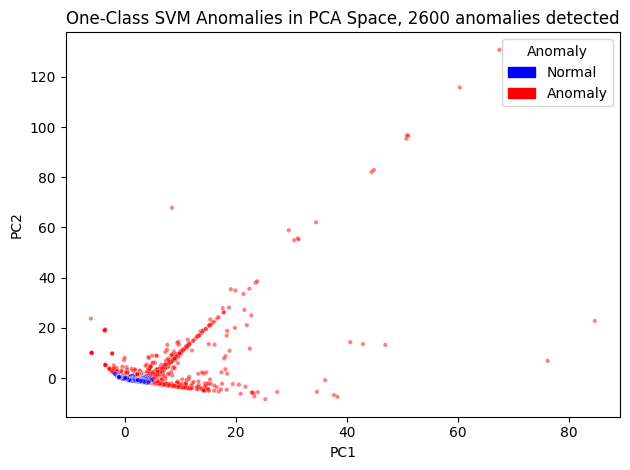

C:\Users\user1\AppData\Local\Temp\ipykernel_14600\1968126179.py:490: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')


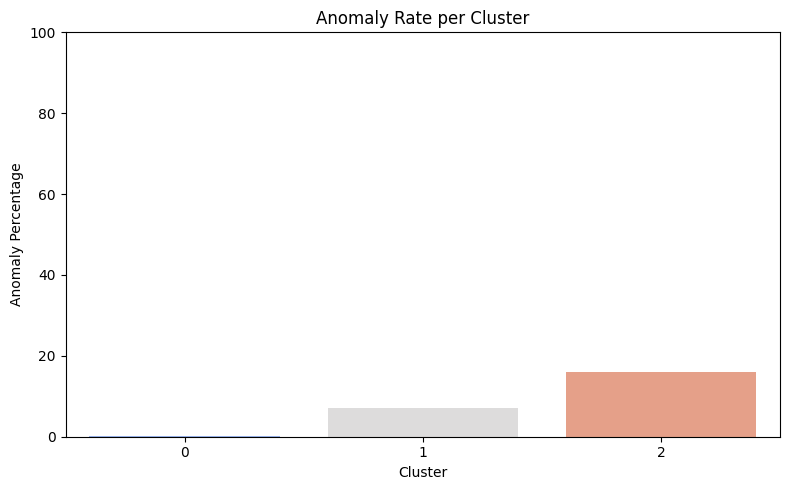

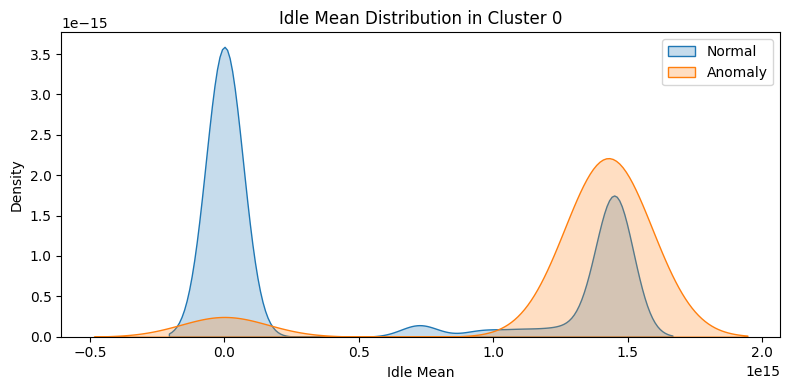

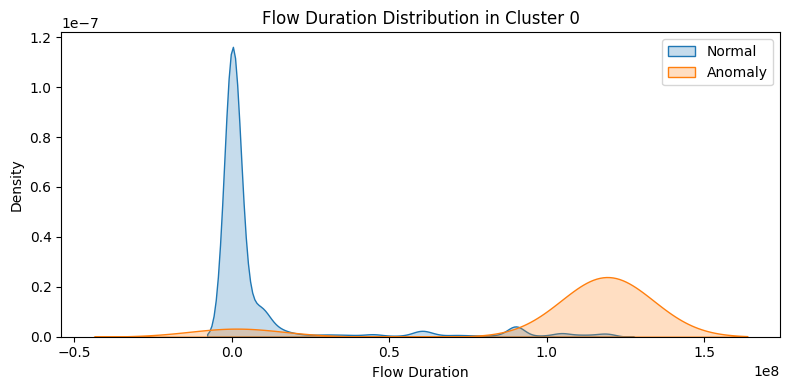

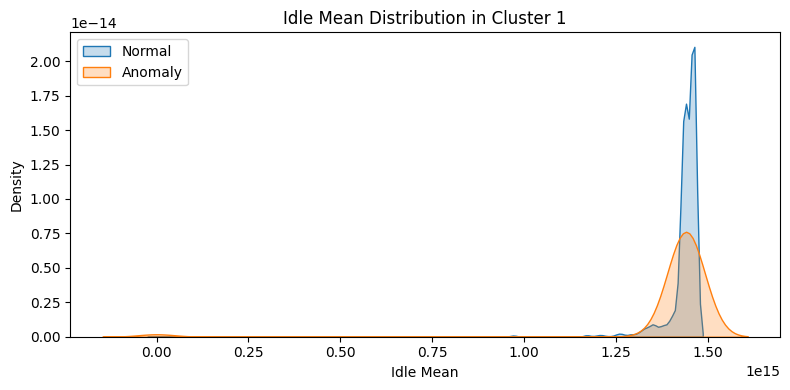

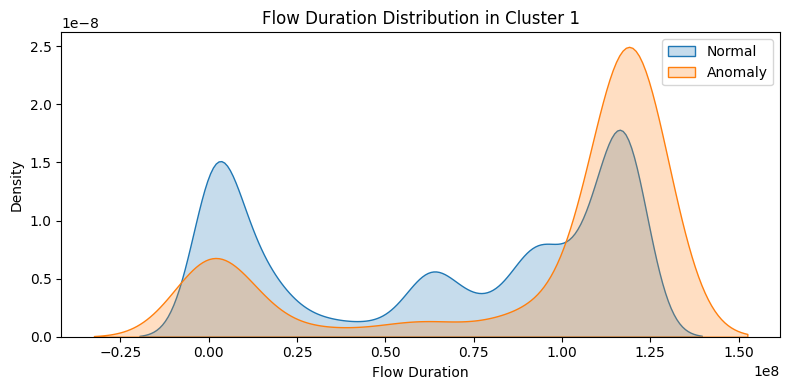

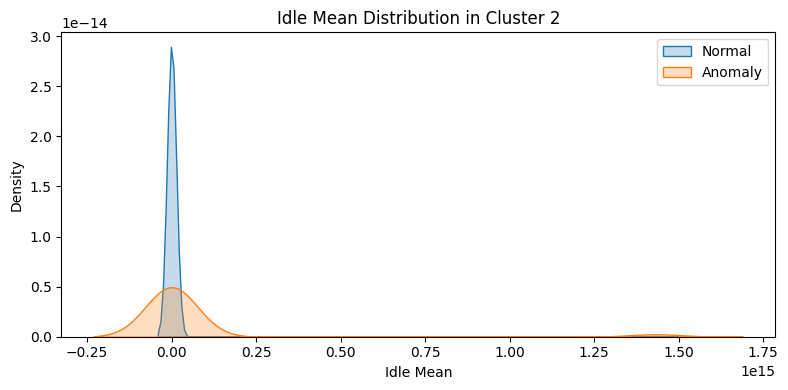

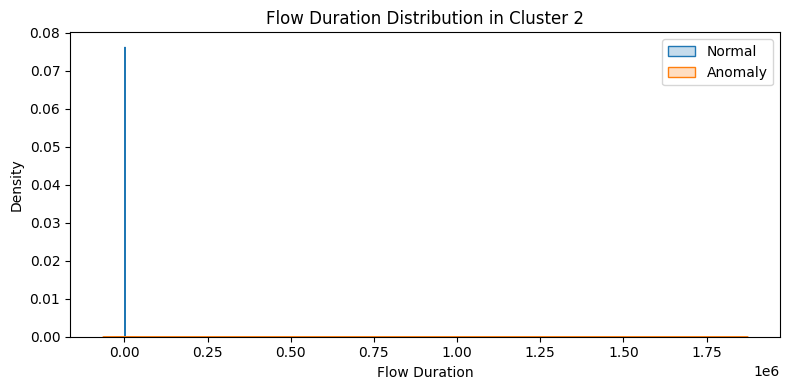

In [39]:

df = detect_anomalies_oneclass_svm_on_pcs(df, pc_scores_df, nu=0.02)

number_of_anomalies_oc = int(df["Anomaly_OCSVM"].fillna(0).sum())
print(f"(OC-SVM) Detected {number_of_anomalies_oc} anomalies out of {len(df)} rows.")

# ---- PCA scatter with OC-SVM overlay (robust hue selection) ----
hue_series = df["Anomaly_OCSVM"].reindex(pc_scores_df.index).fillna(0).map({0: "Normal", 1: "Anomaly"})

sns.scatterplot(
    x=pc_scores_df["PC1"],
    y=pc_scores_df["PC2"],
    hue=hue_series,
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.5, s=10
)
legend_handles = [
    mpatches.Patch(color="blue", label="Normal"),
    mpatches.Patch(color="red", label="Anomaly")
]
plt.title(f"One-Class SVM Anomalies in PCA Space, {number_of_anomalies_oc} anomalies detected")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(handles=legend_handles, title="Anomaly")
plt.tight_layout()
plt.show()

# ---- Reuse your summaries/plots with the new flags ----
tmp = df.copy()
tmp["Anomaly"] = tmp["Anomaly_OCSVM"].fillna(0).astype(int)
summary_df_oc = summarize_anomalies_by_cluster(tmp)
plot_anomaly_rates(summary_df_oc)

key_features = ["Idle Mean", "Flow Duration"]
compare_anomaly_distributions(tmp, key_features)

Detecting Anomalies using Local Outlier Factor

(LOF) Detected 2341 anomalies out of 117025 rows.


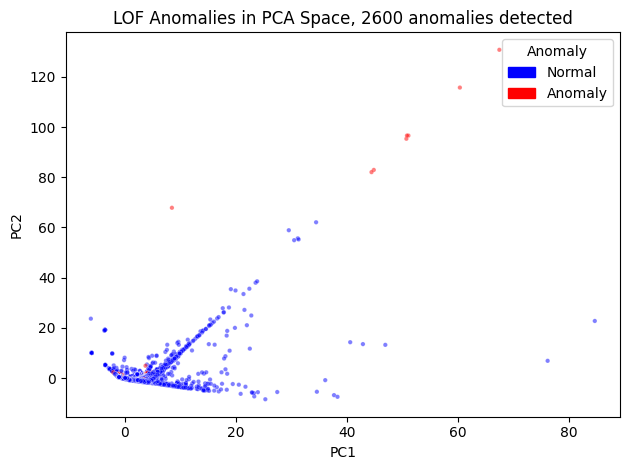

C:\Users\user1\AppData\Local\Temp\ipykernel_14600\1968126179.py:490: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Cluster', y='Anomaly Rate (%)', palette='coolwarm')


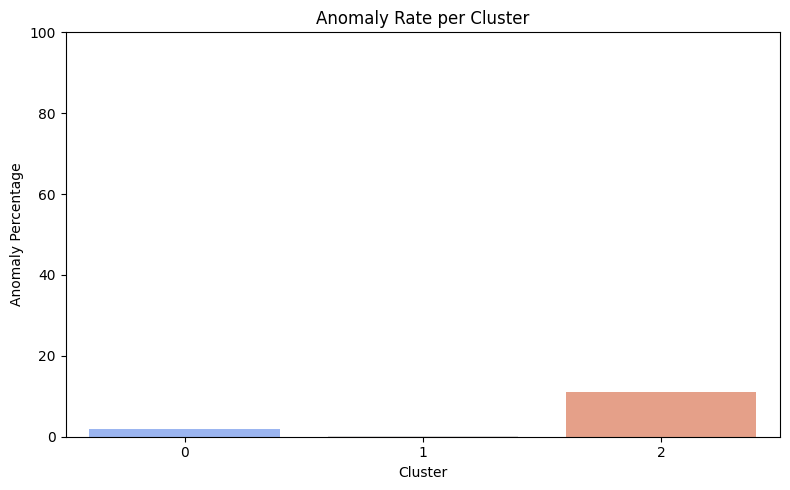

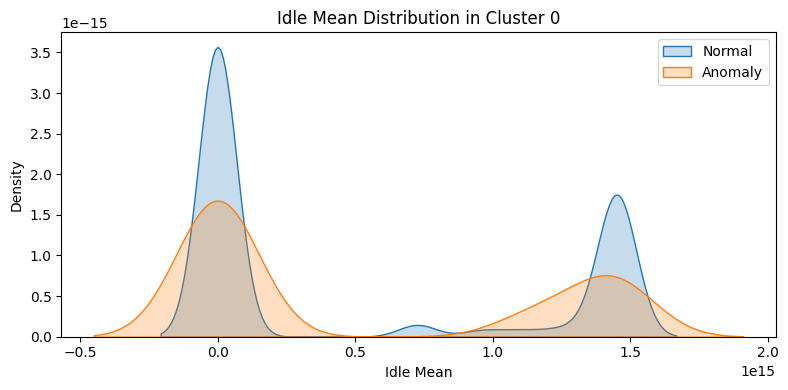

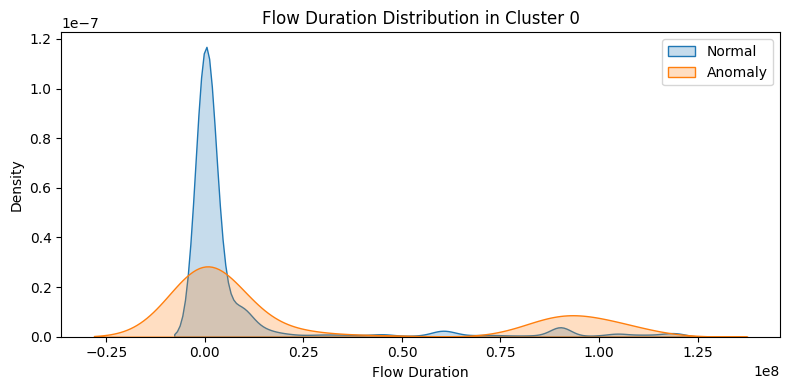

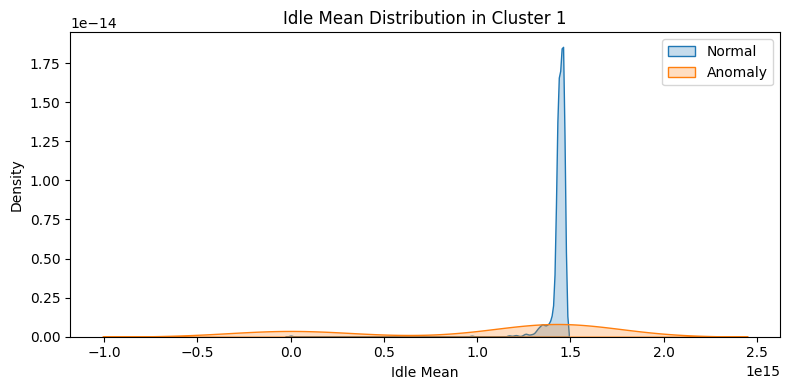

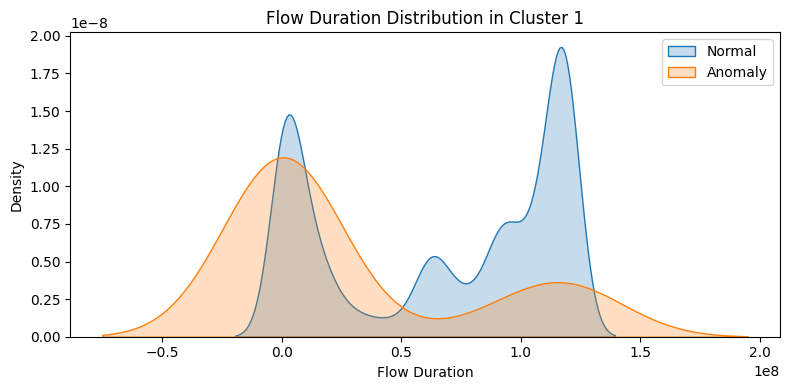

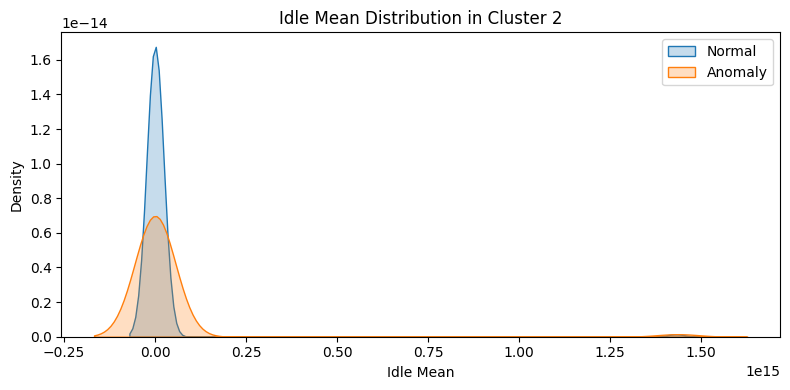

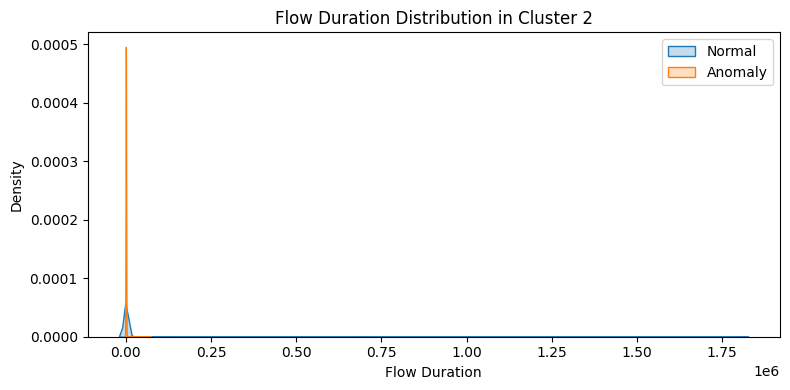

In [40]:
def detect_anomalies_lof_on_pcs(
    df: pd.DataFrame,
    pc_scores_df: pd.DataFrame,
    contamination: float = 0.02,
    n_neighbors: int = 35,
    train_size: int = 20000,   # set to None or 0 to fit on all rows
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Fits LOF on PCA(3) scores (PC1, PC2, PC3) and scores ALL rows.
    Adds/overwrites:
        - 'LOF_Score'   (higher = more anomalous)
        - 'Anomaly_LOF' (0/1)
    Returns df with the two columns aligned by index.
    """
    # 1) Sanity checks
    needed = ["PC1", "PC2", "PC3"]
    missing = [c for c in needed if c not in pc_scores_df.columns]
    if missing:
        raise ValueError(f"pc_scores_df is missing columns: {missing}")

    # 2) Build array and (optionally) a fitting subset
    X_all = pc_scores_df[needed].to_numpy()
    n = len(X_all)

    # If user wants subsampling like OC-SVM:
    if train_size and train_size > 0 and train_size < n:
        rng = np.random.default_rng(random_state)
        fit_idx = rng.choice(n, size=train_size, replace=False)
        X_fit = X_all[fit_idx]
    else:
        X_fit = X_all  # fit on all rows

    # 3) Configure and fit LOF (novelty=True to score all rows after fitting)
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=True,
        metric='euclidean',
        n_jobs=-1
    )
    lof.fit(X_fit)

    # 4) Scores: score_samples -> larger = more normal; flip sign so larger = more anomalous
    lof_score = -lof.score_samples(X_all)

    # 5) Threshold by contamination quantile to get ~contamination fraction as anomalies
    thr = np.quantile(lof_score, 1 - contamination)
    lof_labels = (lof_score >= thr).astype(int)  # 1 = anomaly

    # 6) Build output frame aligned to pc_scores_df
    out = pd.DataFrame(
        {"LOF_Score": lof_score, "Anomaly_LOF": lof_labels},
        index=pc_scores_df.index
    )

    # 7) Drop old columns (prevents "columns overlap" error) and join
    df = df.drop(columns=["LOF_Score", "Anomaly_LOF"], errors="ignore")
    df = df.join(out, how="left")

    return df

df = detect_anomalies_lof_on_pcs(
    df, pc_scores_df,
    contamination=0.02,
    n_neighbors=35,
    train_size=20000,   # or None to fit on all rows
    random_state=42
)

number_of_anomalies_lof = int(df["Anomaly_LOF"].fillna(0).sum())
print(f"(LOF) Detected {number_of_anomalies_lof} anomalies out of {len(df)} rows.")

# ---- PCA scatter with OC-SVM overlay (robust hue selection) ----
hue_series = df["Anomaly_LOF"].reindex(pc_scores_df.index).fillna(0).map({0: "Normal", 1: "Anomaly"})

sns.scatterplot(
    x=pc_scores_df["PC1"],
    y=pc_scores_df["PC2"],
    hue=hue_series,
    palette={"Normal": "blue", "Anomaly": "red"},
    alpha=0.5, s=10
)
legend_handles = [
    mpatches.Patch(color="blue", label="Normal"),
    mpatches.Patch(color="red", label="Anomaly")
]
plt.title(f"LOF Anomalies in PCA Space, {number_of_anomalies_oc} anomalies detected")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(handles=legend_handles, title="Anomaly")
plt.tight_layout()
plt.show()

# ---- Reuse your summaries/plots with the new flags ----
tmp = df.copy()
tmp["Anomaly"] = tmp["Anomaly_LOF"].fillna(0).astype(int)
summary_df_oc = summarize_anomalies_by_cluster(tmp)
plot_anomaly_rates(summary_df_oc)

key_features = ["Idle Mean", "Flow Duration"]
compare_anomaly_distributions(tmp, key_features)

Comparing between Isolation Forest, OC-SVM and LOF

In [41]:
def _to_bool_series(df, col):
    if col not in df.columns:
        return pd.Series(False, index=df.index)
    s = pd.to_numeric(df[col], errors="coerce")
    return s.fillna(0).astype(int).astype(bool)

# Existing flags
a = _to_bool_series(df, "AnomalyIF")         # IF flags
b = _to_bool_series(df, "Anomaly_OCSVM")     # OC-SVM flags
# New: LOF flags
c = _to_bool_series(df, "Anomaly_LOF")       # LOF flags

N = len(df)

# --- Pairwise helper ---
def pairwise_summary(nameA, sA, nameB, sB):
    nA     = int(sA.sum())
    nB     = int(sB.sum())
    both   = int((sA & sB).sum())
    Aonly  = int((sA & ~sB).sum())
    Bonly  = int((~sA & sB).sum())
    agree  = int((sA & sB).sum() + (~sA & ~sB).sum())
    union  = int((sA | sB).sum())
    jacc   = (both / union) if union else np.nan
    agree_rate = (agree / N) if N else np.nan
    return {
        "N": N,
        f"{nameA}_outliers": nA,
        f"{nameB}_outliers": nB,
        "Both": both,
        f"{nameA}_only": Aonly,
        f"{nameB}_only": Bonly,
        "Agreement_rate": round(agree_rate, 4),
        "Jaccard_index": round(jacc, 4),
    }

# --- Pairwise summaries (table with 3 rows) ---
pairwise = pd.DataFrame([
    pairwise_summary("IF", a, "OCSVM", b),
    pairwise_summary("IF", a, "LOF",   c),
    pairwise_summary("OCSVM", b, "LOF", c),
], index=["IF vs OCSVM", "IF vs LOF", "OCSVM vs LOF"])

print("=== Pairwise Summary (Agreement & Jaccard) ===")
display(pairwise)

# --- 3-way summary (Venn-style counts) ---
all_three   = int((a & b & c).sum())
any_two     = int(((a & b & ~c) | (a & ~b & c) | (~a & b & c)).sum())
only_if     = int((a & ~b & ~c).sum())
only_oc     = int((~a & b & ~c).sum())
only_lof    = int((~a & ~b & c).sum())
none        = int((~a & ~b & ~c).sum())
any_anom    = int((a | b | c).sum())
all_equal   = int(((a & b & c) | (~a & ~b & ~c)).sum())
all_equal_rate = round(all_equal / N, 4) if N else np.nan

summary3 = pd.DataFrame([{
    "N": N,
    "Any_anomaly_union": any_anom,
    "All_three": all_three,
    "Exactly_two": any_two,
    "Only_IF": only_if,
    "Only_OCSVM": only_oc,
    "Only_LOF": only_lof,
    "None": none,
    "All_equal_rate": all_equal_rate,  # fraction where all three agree (all 0 or all 1)
}])

print("\n=== 3-way Summary (Venn-style) ===")
display(summary3)

# --- 2×2 contingency tables for each pair ---
cont_if_oc  = pd.crosstab(a.rename("IF"),     b.rename("OCSVM"))
cont_if_lof = pd.crosstab(a.rename("IF"),     c.rename("LOF"))
cont_oc_lof = pd.crosstab(b.rename("OCSVM"),  c.rename("LOF"))

print("\n=== 2×2 Contingency: IF vs OCSVM ===")
display(cont_if_oc)
print("\n=== 2×2 Contingency: IF vs LOF ===")
display(cont_if_lof)
print("\n=== 2×2 Contingency: OCSVM vs LOF ===")
display(cont_oc_lof)

# --- Per-cluster anomaly rates (%), if Cluster column exists ---
if "Cluster" in df.columns:
    cluster_rates = (
        df.assign(IF=a.astype(int), OCSVM=b.astype(int), LOF=c.astype(int))
          .groupby("Cluster")[["IF","OCSVM","LOF"]].mean()
          .mul(100)
          .rename(columns={"IF":"IF_%","OCSVM":"OCSVM_%","LOF":"LOF_%"})
          .reset_index()
    )
    print("\n=== Cluster anomaly rates (% of cluster) ===")
    display(cluster_rates)

=== Pairwise Summary (Agreement & Jaccard) ===


,N,IF_outliers,OCSVM_outliers,Both,IF_only,OCSVM_only,Agreement_rate,Jaccard_index,LOF_outliers,LOF_only
IF vs OCSVM,117025,2341.0,2600.0,1152,1189.0,1448.0,0.9775,0.3040,NaN,NaN
IF vs LOF,117025,2341.0,NaN,29,2312.0,NaN,0.9605,0.0062,2341.0,2312.0
OCSVM vs LOF,117025,NaN,2600.0,225,NaN,2375.0,0.9616,0.0477,2341.0,2116.0



=== 3-way Summary (Venn-style) ===


,N,Any_anomaly_union,All_three,Exactly_two,Only_IF,Only_OCSVM,Only_LOF,None,All_equal_rate
0,117025,5905,29,1319,1189,1252,2116,111120,0.9498



=== 2×2 Contingency: IF vs OCSVM ===


OCSVM,False,True
IF,,
False,113236,1448
True,1189,1152



=== 2×2 Contingency: IF vs LOF ===


LOF,False,True
IF,,
False,112372,2312
True,2312,29



=== 2×2 Contingency: OCSVM vs LOF ===


LOF,False,True
OCSVM,,
False,112309,2116
True,2375,225



=== Cluster anomaly rates (% of cluster) ===


,Cluster,IF_%,OCSVM_%,LOF_%
0,0,0.000000,0.145818,1.823282
1,1,10.837322,7.084301,0.151637
2,2,0.887574,16.009204,11.028928


In [42]:
# Helper: robust IQR
def _iqr(x):
    q1, q3 = np.percentile(x, [25, 75])
    return float(q3 - q1)

# Build a distance-to-origin in PCA space (good, label-free sanity metric)
pc_cols = [c for c in ["PC1","PC2","PC3"] if c in pc_scores_df.columns]
pca_dist = np.sqrt((pc_scores_df[pc_cols]**2).sum(axis=1)) if pc_cols else None

# Configure the detectors you want to summarize (flag col, optional score col)
detectors = [
    {"name":"IF",     "flag":"AnomalyIF",     "score":"IF_Score"},
    {"name":"OCSVM",  "flag":"Anomaly_OCSVM", "score":"OCSVM_Score"},
    {"name":"LOF",    "flag":"Anomaly_LOF",   "score":"LOF_Score"},
]

rows = []
cluster_tables = {}  # per-detector cluster tables for optional display

for d in detectors:
    name, fcol, scol = d["name"], d["flag"], d["score"]
    if fcol not in df.columns:
        continue
    flags = pd.to_numeric(df[fcol], errors="coerce").fillna(0).astype(int)
    n = len(flags)
    n_out = int(flags.sum())
    rate = n_out / n if n else np.nan

    # Score summaries (if available)
    has_score = (scol in df.columns)
    if has_score:
        s = pd.to_numeric(df[scol], errors="coerce")
        s_norm = s[flags==0].dropna()
        s_anom = s[flags==1].dropna()
        score_med_norm = float(np.median(s_norm)) if len(s_norm) else np.nan
        score_iqr_norm = _iqr(s_norm) if len(s_norm) else np.nan
        score_med_anom = float(np.median(s_anom)) if len(s_anom) else np.nan
        score_iqr_anom = _iqr(s_anom) if len(s_anom) else np.nan
    else:
        score_med_norm = score_iqr_norm = score_med_anom = score_iqr_anom = np.nan

    # PCA distance summaries (if we built pca_dist)
    if pca_dist is not None:
        dn = pca_dist[flags==0]
        da = pca_dist[flags==1]
        dist_med_norm = float(np.median(dn)) if len(dn) else np.nan
        dist_med_anom = float(np.median(da)) if len(da) else np.nan
    else:
        dist_med_norm = dist_med_anom = np.nan

    # Per-cluster concentration (which cluster has highest anomaly %)
    peak_cluster = None
    peak_rate = np.nan
    if "Cluster" in df.columns:
        tbl = (df.assign(_flag=flags)
                 .groupby("Cluster")["_flag"].agg(["sum","count"]))
        tbl["rate_%"] = 100 * tbl["sum"] / tbl["count"]
        cluster_tables[name] = tbl.sort_values("rate_%", ascending=False)
        if len(tbl):
            peak_cluster = int(tbl["rate_%"].idxmax())
            peak_rate = float(tbl["rate_%"].max())

    rows.append({
        "Detector": name,
        "N": n,
        "Outliers": n_out,
        "Outlier_rate_%": round(100*rate, 2),
        "Target_rate_%": 2.0,  # your chosen contamination
        "Abs_diff_pts": round(100*rate - 2.0, 2),
        "Score_med_norm": score_med_norm,
        "Score_IQR_norm": score_iqr_norm,
        "Score_med_anom": score_med_anom,
        "Score_IQR_anom": score_iqr_anom,
        "PCA_dist_med_norm": dist_med_norm,
        "PCA_dist_med_anom": dist_med_anom,
        "Peak_cluster": peak_cluster,
        "Peak_cluster_rate_%": round(peak_rate, 2) if not np.isnan(peak_rate) else np.nan,
    })

standalone_metrics = pd.DataFrame(rows)
print("=== Standalone Evaluation Metrics (per detector) ===")
display(standalone_metrics)

# (Optional) also show per-detector cluster tables sorted by highest anomaly rate
for det, tbl in cluster_tables.items():
    print(f"\n--- Per-cluster table for {det} (sorted by anomaly %) ---")
    display(tbl.sort_values("rate_%", ascending=False))


=== Standalone Evaluation Metrics (per detector) ===


,Detector,N,Outliers,Outlier_rate_%,Target_rate_%,Abs_diff_pts,Score_med_norm,Score_IQR_norm,Score_med_anom,Score_IQR_anom,PCA_dist_med_norm,PCA_dist_med_anom,Peak_cluster,Peak_cluster_rate_%
0,IF,117025,2341,2.00,2.0,0.00,NaN,NaN,NaN,NaN,1.151279,3.933641,1,10.84
1,OCSVM,117025,2600,2.22,2.0,0.22,-3.319134,4.145762,1.646342,23.859932,1.146592,4.548608,2,16.01
2,LOF,117025,2341,2.00,2.0,0.00,1.024131,0.128813,105.035541,675541.021237,1.157386,1.157661,2,11.03



--- Per-cluster table for IF (sorted by anomaly %) ---


,sum,count,rate_%
Cluster,,,
1,2287,21103,10.837322
2,54,6084,0.887574
0,0,89838,0.000000



--- Per-cluster table for OCSVM (sorted by anomaly %) ---


,sum,count,rate_%
Cluster,,,
2,974,6084,16.009204
1,1495,21103,7.084301
0,131,89838,0.145818



--- Per-cluster table for LOF (sorted by anomaly %) ---


,sum,count,rate_%
Cluster,,,
2,671,6084,11.028928
0,1638,89838,1.823282
1,32,21103,0.151637


Non-numeric Validation

In [43]:
df = df[df["Label"] != "5494.505495"].copy()

if "Timestamp" in df.columns and not np.issubdtype(df["Timestamp"].dtype, np.datetime64):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)
if "Timestamp" in df.columns:
    df["Hour"] = df["Timestamp"].dt.hour
    df["Dow"] = df["Timestamp"].dt.dayofweek
    df["Weekend"] = (df["Dow"] >= 5).astype(int)
    df["PartOfDay"] = pd.cut(df["Hour"], [-1,5,11,17,23], labels=["Night","Morning","Afternoon","Evening"])

def label_enrichment(df, flag_col):
    if "Label" not in df.columns: 
        return None
    allc = df["Label"].value_counts(dropna=False)
    flgc = df.loc[df[flag_col]==1, "Label"].value_counts(dropna=False)
    out = pd.DataFrame({"All": allc, "Flagged": flgc.reindex(allc.index, fill_value=0)})
    out["All_%"] = (out["All"]/out["All"].sum()*100).round(2)
    out["Flagged_%"] = (out["Flagged"]/out["Flagged"].sum()*100).round(2)
    return out

enrich_if = label_enrichment(df, "AnomalyIF")
enrich_oc = label_enrichment(df, "Anomaly_OCSVM")
display(enrich_if); display(enrich_oc)

C:\Users\user1\AppData\Local\Temp\ipykernel_14600\2778034365.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)


,All,Flagged,All_%,Flagged_%
Label,,,,
Non-Tor,69065,963,59.02,41.14
NonVPN,23861,330,20.39,14.10
VPN,22919,480,19.58,20.50
Tor,1179,568,1.01,24.26


,All,Flagged,All_%,Flagged_%
Label,,,,
Non-Tor,69065,1362,59.02,52.38
NonVPN,23861,634,20.39,24.38
VPN,22919,295,19.58,11.35
Tor,1179,309,1.01,11.88


Fit/Approximation Quality Diagnostics (train/test drift, seed stability, SV fraction)


In [44]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

RATE   = 0.02        # target outlier rate (2%)
SEED   = 42
FIT_N  = 20000       # OC-SVM fit subsample size (for speed)
STAB_N = 50000       # stability subset size (for speed on ~130k rows)

# 7.1: Build the feature matrix Z (prefer PCA; fallback to standardized raw numeric) --------
def get_feature_matrix(df, selected_columns, pc_scores_df=None):
    # Prefer PCA if present
    if pc_scores_df is not None:
        pc_cols = [c for c in pc_scores_df.columns if str(c).upper().startswith("PC")]
        if len(pc_cols) >= 2:
            Z = pc_scores_df[pc_cols].to_numpy()
            return Z, "PCA", pc_scores_df.index

    # Fallback: standardized raw selected_columns
    if selected_columns is None or len(selected_columns) == 0:
        # fallback to all numeric columns
        selected_columns = df.select_dtypes(include="number").columns.tolist()
    X = df[selected_columns]
    X = X.dropna()  # use rows with all features available
    Z = StandardScaler().fit_transform(X.to_numpy())
    return Z, "RAW_std", X.index

# Try to use PCA if available in your notebook
try:
    Z, feat_space, Z_index = get_feature_matrix(df, selected_columns, pc_scores_df)
except NameError:
    Z, feat_space, Z_index = get_feature_matrix(df, selected_columns, None)

print(f"[Diagnostics] Feature space: {feat_space} | Z shape: {Z.shape}")

#  Train/Test drift (calibrate 2% on TRAIN, measure % flagged on TEST) --------
idx_all = np.arange(Z.shape[0])
idx_tr, idx_te = train_test_split(idx_all, test_size=0.30, random_state=SEED, shuffle=True)
Z_tr, Z_te = Z[idx_tr], Z[idx_te]

# Isolation Forest: threshold from train, apply to test
ifm = IsolationForest(contamination=RATE, random_state=SEED).fit(Z_tr)
sc_tr_if = -ifm.score_samples(Z_tr)   # higher = more anomalous
sc_te_if = -ifm.score_samples(Z_te)
thr_if   = np.quantile(sc_tr_if, 1 - RATE)
rate_if_te = float((sc_te_if >= thr_if).mean())

# One-Class SVM: fit on subsample of TRAIN, threshold on TRAIN, apply to TEST
rng = np.random.default_rng(SEED)
fit_idx_tr = rng.choice(Z_tr.shape[0], size=min(FIT_N, Z_tr.shape[0]), replace=False)
oc = OneClassSVM(kernel="rbf", gamma="scale", nu=RATE).fit(Z_tr[fit_idx_tr])
f_tr = oc.decision_function(Z_tr); f_te = oc.decision_function(Z_te)
sc_tr_oc = -f_tr; sc_te_oc = -f_te
thr_oc   = np.quantile(sc_tr_oc, 1 - RATE)
rate_oc_te = float((sc_te_oc >= thr_oc).mean())

drift_df = pd.DataFrame([{
    "Feature_Space": feat_space,
    "Train_target_%": RATE*100,
    "Test_rate_IF_%": round(rate_if_te*100, 2),
    "Test_rate_OCSVM_%": round(rate_oc_te*100, 2)
}])
display(drift_df)
drift_df.to_csv("fit_quality_train_test_drift.csv", index=False)

#Seed stability (mean pairwise Jaccard across seeds), on a subset for speed --------
def jaccard(a, b):
    u = (a | b).sum()
    return (a & b).sum() / u if u else np.nan

# pick a stability subset once
stab_rng = np.random.default_rng(SEED)
stab_idx = stab_rng.choice(Z.shape[0], size=min(STAB_N, Z.shape[0]), replace=False)
Z_stab   = Z[stab_idx]

SEEDS = [21, 42, 84]

def flags_if_on(Zmat, rate, seed):
    m = IsolationForest(contamination=rate, random_state=seed).fit(Zmat)
    sc = -m.score_samples(Zmat)
    thr = np.quantile(sc, 1 - rate)
    return sc >= thr

def flags_oc_on(Zmat, rate, seed, fit_n=FIT_N):
    rng = np.random.default_rng(seed)
    fit_idx = rng.choice(Zmat.shape[0], size=min(fit_n, Zmat.shape[0]), replace=False)
    m = OneClassSVM(kernel="rbf", gamma="scale", nu=rate).fit(Zmat[fit_idx])
    sc = -m.decision_function(Zmat)
    thr = np.quantile(sc, 1 - rate)
    return sc >= thr

IF_flags = [flags_if_on(Z_stab, RATE, s) for s in SEEDS]
OC_flags = [flags_oc_on(Z_stab, RATE, s) for s in SEEDS]

def mean_pairwise_jaccard(flags_list):
    k = len(flags_list)
    vals = []
    for i in range(k):
        for j in range(i+1, k):
            vals.append(jaccard(flags_list[i], flags_list[j]))
    return float(np.nanmean(vals)) if vals else np.nan

mean_j_if = mean_pairwise_jaccard(IF_flags)
mean_j_oc = mean_pairwise_jaccard(OC_flags)

stab_df = pd.DataFrame([{
    "Feature_Space": feat_space,
    "Mean_Jaccard_IF": round(mean_j_if, 3),
    "Mean_Jaccard_OCSVM": round(mean_j_oc, 3),
    "Subset_size": Z_stab.shape[0]
}])
display(stab_df)
stab_df.to_csv("fit_quality_seed_stability.csv", index=False)

# -------- 7.4: OC-SVM support-vector fraction (theory check) --------
sv_frac = len(oc.support_) / len(fit_idx_tr)   # oc from 7.2 (TRAIN subsample)
sv_df = pd.DataFrame([{
    "nu": RATE,
    "Support_Vector_Fraction": round(sv_frac, 3),
    "Fit_size": len(fit_idx_tr),
    "Feature_Space": feat_space
}])
display(sv_df)
sv_df.to_csv("fit_quality_ocsvm_sv_fraction.csv", index=False)

print("\nSaved: fit_quality_train_test_drift.csv, fit_quality_seed_stability.csv, fit_quality_ocsvm_sv_fraction.csv")


[Diagnostics] Feature space: PCA | Z shape: (117025, 3)


,Feature_Space,Train_target_%,Test_rate_IF_%,Test_rate_OCSVM_%
0,PCA,2.0,2.0,2.04


,Feature_Space,Mean_Jaccard_IF,Mean_Jaccard_OCSVM,Subset_size
0,PCA,0.854,0.659,50000


,nu,Support_Vector_Fraction,Fit_size,Feature_Space
0,0.02,0.02,20000,PCA



Saved: fit_quality_train_test_drift.csv, fit_quality_seed_stability.csv, fit_quality_ocsvm_sv_fraction.csv


Cluster Interpretation

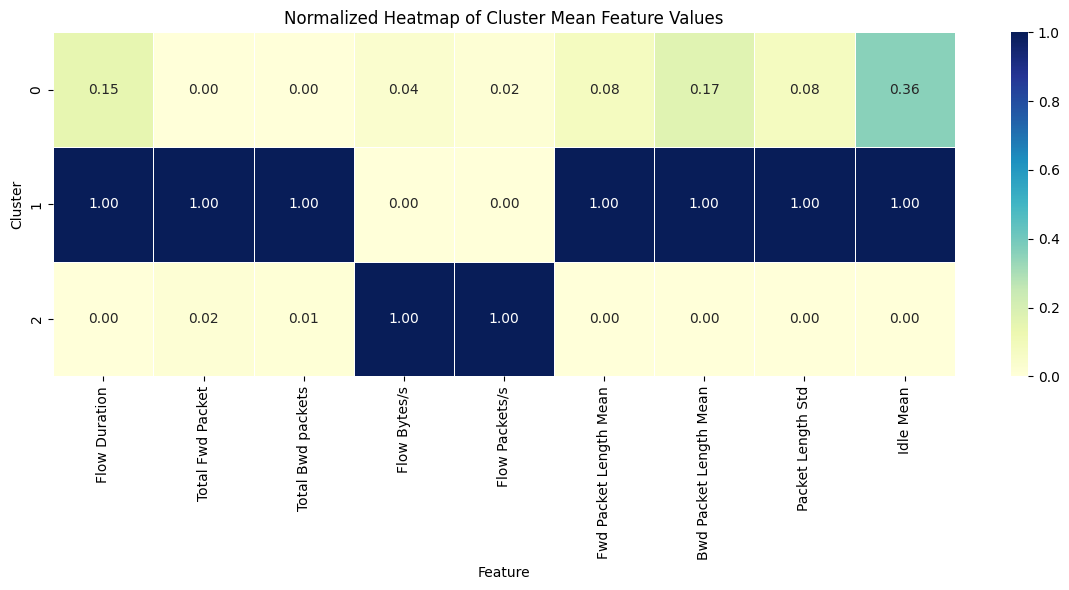

In [45]:
summary_df = interpret_clusters(df, selected_columns)
summary_df.to_csv("cluster_summary.csv", index=True)
plot_normalized_cluster_mean_heatmap(df, selected_columns, cluster_col='Cluster')

Temporal feature engineering

In [46]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['Timestamp'])  # remove rows with bad timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.day_name()
df['WeekGroup'] = df['DayOfWeek'].apply(lambda x: 'DuringWeek' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday'] else 'Weekend')
df['PartOfDay'] = pd.cut(
    df['Hour'],
    bins=[6, 12, 18, 24],
    labels=['Morning', 'Afternoon', 'Evening'],
    right=False
)

Temporal Analysis - depending on the Time of day and Week

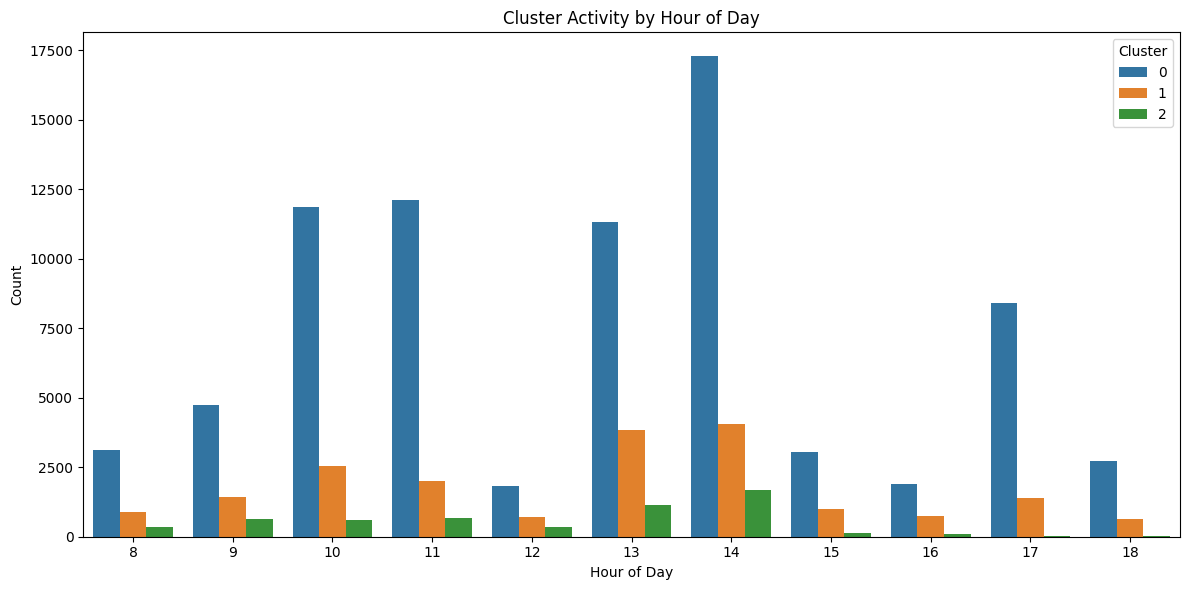

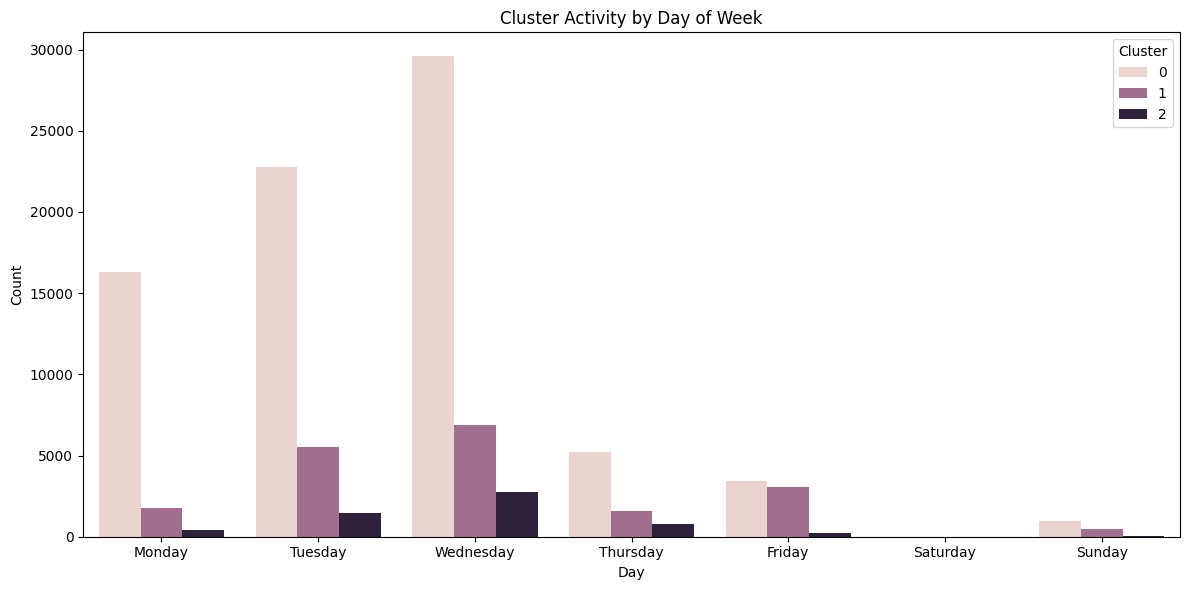

In [47]:
temporal_analysis("DarknetWorking_with_outliers.csv", timestamp_col="Timestamp", cluster_col="Cluster")

temporal_ks = run_temporal_ks_tests(df, selected_columns, time_col='PartOfDay', cluster_col='Cluster')
temporal_ks.to_csv("temporal_ks_results.csv", index=False)

temporal_ks = run_temporal_ks_tests(df, selected_columns, time_col='WeekGroup', cluster_col='Cluster')
temporal_ks.to_csv("temporal_ks_resultsday.csv", index=False)

Visualize Temporal Differences

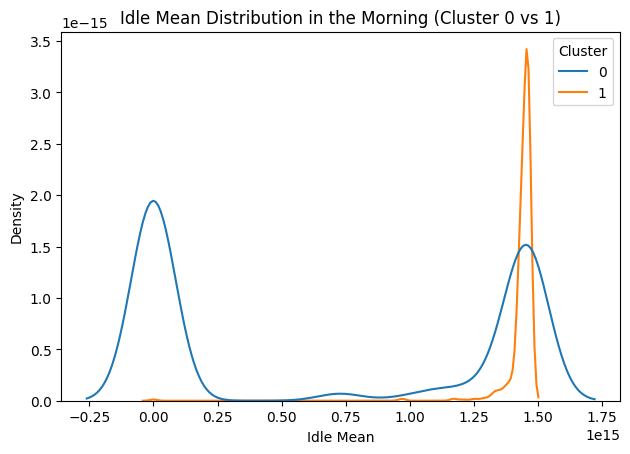

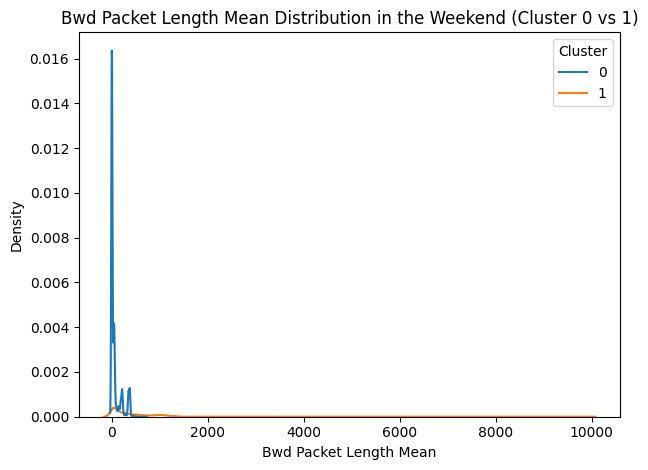

In [48]:
sns.kdeplot(data=df[df['Cluster'].isin([0,1]) & (df['PartOfDay'] == 'Morning')], x='Idle Mean', hue='Cluster')
plt.title("Idle Mean Distribution in the Morning (Cluster 0 vs 1)")
plt.xlabel("Idle Mean")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


sns.kdeplot(data=df[df['Cluster'].isin([0,1]) & (df['WeekGroup'] == 'DuringWeek')], x='Bwd Packet Length Mean', hue='Cluster')
plt.title("Bwd Packet Length Mean Distribution in the Weekend (Cluster 0 vs 1)")
plt.xlabel("Bwd Packet Length Mean")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Information Flow Graph - To look at connections from source to destination

Showing only 100.


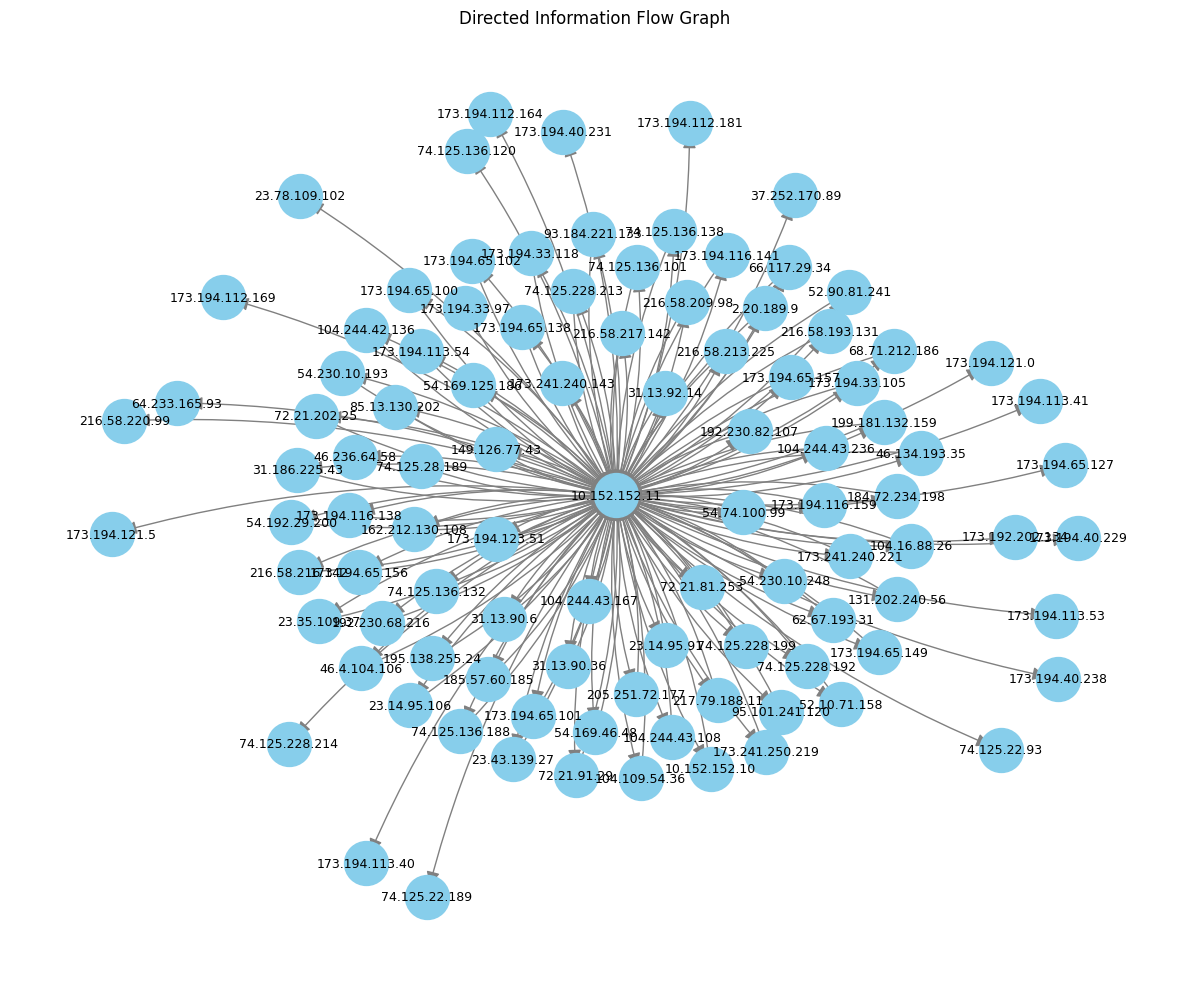

In [49]:
G = build_info_flow_graph(df)
plot_info_flow_graph(G)

Looking at data by differentiating idle mean (low vs. high)

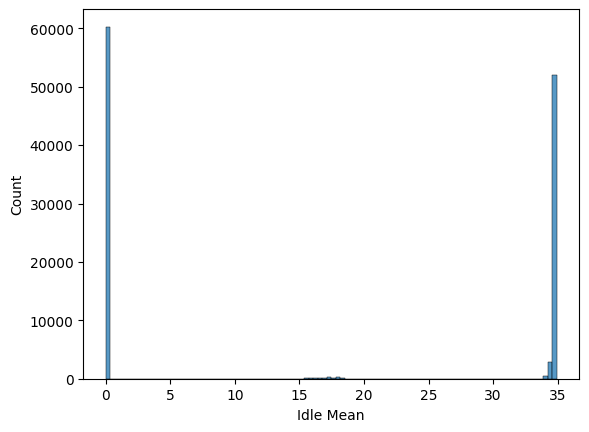

AnomalyIF anomaly rate by mode:
Idle_Mode
High-Idle    4.085912
Low-Idle     0.036504
Name: AnomalyIF, dtype: float64

Anomaly_OCSVM anomaly rate by mode:
Idle_Mode
High-Idle    2.866657
Low-Idle     1.614455
Name: Anomaly_OCSVM, dtype: float64

Anomaly_LOF anomaly rate by mode:
Idle_Mode
High-Idle    1.194587
Low-Idle     2.759342
Name: Anomaly_LOF, dtype: float64



PartOfDay,Morning,Afternoon,Evening
Idle_Mode,,,
High-Idle,56.186008,43.982774,35.674074
Low-Idle,43.813992,56.017226,64.325926


In [50]:
idle = df["Idle Mean"].dropna()

# Quick histogram to eyeball where the split should be
sns.histplot(np.log1p(idle), bins=100)   # log1p because of scale
plt.show()

# Suppose the valley is around threshold T
T = idle.median()   # or better: manually pick ~ midpoint between the two peaks
df["Idle_Mode"] = np.where(df["Idle Mean"] <= T, "Low-Idle", "High-Idle")

pd.crosstab(df["Idle_Mode"], df["Cluster"], normalize="index") * 100

for col in ["AnomalyIF","Anomaly_OCSVM","Anomaly_LOF"]:
    if col in df.columns:
        rates = df.groupby("Idle_Mode")[col].mean()*100
        print(f"{col} anomaly rate by mode:\n{rates}\n")

pd.crosstab(df["Idle_Mode"], df["PartOfDay"], normalize="columns") * 100

Summary: As my dataset was static, there was no learning curve to examine or reinforcement learning to model. Instead, I approached the problem through multiple perspectives to build a fuller picture of how the variables connect using unsupervised clustering methods. PCA allowed me to reduce dimensionality to three components, preserving much of the variance while simplifying analysis. K-Means then revealed distinct behavioral clusters, which were further validated through Kolmogorov–Smirnov tests showing meaningful differences in idle time patterns. Finally, network graph analysis highlighted the presence of a central hub node driving a large share of traffic.